# Fit atmosphere parameters Airmass, VAOD, PWV, O3, including clouds OD

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : September 15th 2020


# imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
from astropy.table import Table

In [4]:
from scipy import interpolate

In [5]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [6]:
# analytic for removing rayleigh
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [7]:
import libatmscattering as atm

In [8]:
import seaborn as sns

In [9]:
# pysynphot
import pysynphot as S

In [10]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [11]:
import scipy.special as sp

In [12]:
PATH_LSSTFiltersKG='../../data/lsst/LSSTFiltersKG'
sys.path.append(PATH_LSSTFiltersKG)
PATH_LSSTFiltersKGDATA='../../data/lsst/LSSTFiltersKG/fdata'
sys.path.append(PATH_LSSTFiltersKGDATA)

In [13]:
import libLSSTFiltersKG as lsst

liblsstfilter_path= ../../data/lsst/LSSTFiltersKG


In [14]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

# Pre defined Functions

In [15]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

## Functions to select the CALSPEC

In [16]:
def GetListOfCalspec(file_sedsummary="sed/table_summary_allcalspec_torenorm.fits"):
    """
    GetListOfCalspec()
    
    the file include SED fro which color term has been caculated 
    in /examples_sed/calspec/ViewCalspecColors.ipynb
    
    - input:
      file_sedsummary : filename of SED summary
      
    - output:
      t : astropy table of summary 
    """

    t=Table.read(file_sedsummary)
    return t

In [17]:
def SelectFewSED(t):
    """
    SelectFewSED(t)
    
    input : 
     - t astropy table of SED
     
    output :
    - t_selected : table of presselected SED
     
    """
    
    all_colors=t["VmI"]
    
    
    # list of target colors
    target_VmI=np.array([-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
    NBVmItarget=len(target_VmI)
    
    filesselected_index=np.zeros(NBVmItarget)
    filesselected_VmI=np.zeros(NBVmItarget)
    
    idx=0
    for vmi in target_VmI:
        thevmi,theidx=find_nearest(all_colors,vmi)
        #print(thevmi,theidx)
        filesselected_index[idx]=int(theidx)
        filesselected_VmI[idx]=thevmi
        idx+=1  
        
    t_selected=Table(t[0])
    for idx in filesselected_index[1:]:
        t_selected.add_row(t[int(idx)])
        
    return t_selected
    

In [18]:
def plot_sed(t,ax):
    """
    """
    
    NBFILES=len(t)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBFILES)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBFILES), alpha=1)
    
    idx=0
    
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')

    for filename in t["FILES"]:
    
    
        fullfilename=os.path.join(path_sed_calspec,filename)
        
        if filename=="flat":
            spec=flatsp
            spec_norm=spec
        else:
            spec=S.FileSpectrum(fullfilename)
        
        spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
        spec_norm.convert('photlam')
        #spec_norm.convert('nm')    
        
        #WLMINSEL=340.
        #WLMAXSEL=1100.


        magV=t["magV"][idx]
        label=t["OBJNAME"][idx]+" ( "+t["SP_TYPE"][idx]+" ) "+" magV = {:.2g}".format(magV) +" v-i ={:.2f}".format(t["VmI"][idx])
        
        
        
        #X= spec_norm.wave[wavelengths_indexes]    
        #Y= spec_norm.flux[wavelengths_indexes]  
        
        X= spec_norm.wave   
        Y= spec_norm.flux 
        
        wavelengths_indexes=np.where(np.logical_and(spec_norm.wave>WLMINSEL*10, spec_norm.wave<WLMAXSEL*10))[0]
        
        
        #if filename!="flat":
        cm=ax.plot(X[wavelengths_indexes], Y[wavelengths_indexes],color=all_colors[idx],label=label)
        
        idx+=1
    
    #ax.set_xlim(3500.,11000.)
    #ax.set_ylim(0.,3.)
    ax.legend()
    ax.grid()


    xlabel=' $\\lambda$ (Angstrom)'
    ylabel=' Flux (photlam) normalised to Mag-10'
    ax.set_xlabel(xlabel,fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    ax.set_title("Preselected CALSPEC relative SED")
    
    return cm

    
    

## Functions to build spectrum 

In [19]:
def GetSpectra(sed,wl_atm,atm_transmission, order2=False):
    """
    
    * input : 
     - sed : Pysynphot SED
     -  wl  : wavelength of the atmospheric transmission (nm)
     - transmission : atmospheric transmission array
     - order2 : flag to compute the atmospheric transmission
     
    * output :
     - array of spectra (corresponding to wl in nm)
    
    """
    
    wl0=sed.wave  # in angstrom
    spectra=np.zeros_like(atm_transmission)
    spectra2=np.zeros_like(atm_transmission)  # order 2
    
    wl_atm_ang=10*wl_atm
    
    
    
    # quantum efficiency
    wl_ccd,throughput,ccdqe,trans_opt_elec=lsst.GetThroughputAndCCDQE("../../data/lsst")
    bp_qe= S.ArrayBandpass(wl_ccd*10.,ccdqe, name='QE')
    
    
    
    # passband for atmosphere
    Natm=atm_transmission.shape[0]
    all_bp_atm=[]
    for i_atm in np.arange(Natm):
        label_atm="atm{:d}".format(i_atm)
        bp_atm= S.ArrayBandpass(wl_atm_ang,atm_transmission[i_atm,:], name=label_atm)
        all_bp_atm.append(bp_atm)
        
    # Hologram transmission (analytic)
    X0=10000 # in antstrom
    X=wl0
    X2=np.sort(np.unique(np.concatenate((wl0/2,wl0)))) 
    Eff_holo=sp.jv(1, X0/X)**2
    Eff_holo2=sp.jv(2, X0/X2)**2
    
    bp_holo_order1= S.ArrayBandpass(X,Eff_holo, name='Holo')
    bp_holo_order2= S.ArrayBandpass(X2,Eff_holo2, name='Holo2')
    
    all_obs1=[]
    all_obs2=[]
    
    # compute spectra for order 1 and order 2
    for i_atm in np.arange(Natm):
        bp_all_order1=bp_qe*all_bp_atm[i_atm]* bp_holo_order1
        bp_all_order2=bp_qe*all_bp_atm[i_atm]* bp_holo_order2

        obs1 = S.Observation(sed, bp_all_order1,force='taper') # order 1
        obs2 = S.Observation(sed, bp_all_order2,force='taper') # order 2
    
        all_obs1.append(obs1)
        all_obs2.append(obs2)
        
   
    for i_atm in np.arange(Natm):
        obs1=all_obs1[i_atm]
        func_order1 = interpolate.interp1d(obs1.binwave,obs1.binflux,bounds_error=False,fill_value=(0,0))
    
        spectra[i_atm,:]=func_order1(wl_atm_ang) 
    
        obs2=all_obs2[i_atm]
        func_order2 = interpolate.interp1d(2*obs2.binwave,obs2.binflux/2,bounds_error=False,fill_value=(0,0))
        spectra2[i_atm,:]=func_order2(wl_atm_ang) 
        
    # add order 1 + order 2    
    if order2:
        spectra=spectra+spectra2
        
    spectra=spectra*10 # to get per unit of nm
    spectra2=spectra2*10
    
    return spectra,spectra2
    
    

In [20]:
if 0:
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm[:22,:],order2=True)
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(20):
        ax.plot(wl,spectra[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()
    
    ax = fig.add_subplot(122)
    for idx in np.arange(20):
        ax.plot(wl,spectra2[idx,:])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

## Functions for Plotting

In [21]:
def plot_param(iparam,ax,all_Yin,all_Yout,mode,nsig=10):
    """
    plot parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    xlabel=["VAOD in ","PWV in (mm)","Ozone in (dBU)","Cloud OD in "]
    ylabel=["value out","value rec - value in","$\delta V/V$"]
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]
     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    
    if mode   ==0:  
        cm=ax.plot(Y0,Y1,"o",color=all_colors[iparam])
    elif mode ==1:
        
        mu = DY.mean()
        median = np.median(DY)
        sigma = DY.std()
        textstr = '\n'.join((
        r'$\mu$={:3.2g}'.format(mu),
        r'$median$={:3.2g}'.format(median),
        r'$\sigma$={:3.2g}'.format(sigma)))
        
       
        cm=ax.plot(Y0,DY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
        
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)
        
    else:
        
        mu = RY.mean()
        median = np.median(RY)
      
        sigma = RY.std()
        
        
        textstr = '\n'.join((
        '$\mu$={:.3g}'.format(mu),
        '$median$={:.3g}'.format(median),
        '$\sigma$={:.3g}'.format(sigma)))
       
        
        
        cm=ax.plot(Y0,RY,"o",color=all_colors[iparam])
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
            
        ax.set_ylim(mu-nsig*sigma,mu+nsig*sigma)    
            
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel[mode])

    
    ax.ticklabel_format(axis='y',style='sci', 
                          scilimits=None, 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [22]:
def plot_param_histo(iparam,ax,all_Yin,all_Yout,nsig=10):
    """
    plot histo of parameters
    
    iparam = 0,1,2,3 : VAOD,PWV,O3,CLD
    ax     = axis
    
    all_Yin : inverse transform of the input in the simulation
    all_Yout : inverse transform predicted parameters
    
    mode : 
    - 0 : Yout vs Yin
    - 1 : Yout - Yin vs Yin
    - 2 : (Yout - Yin)/Yin vs Yin
    
    """
    N=4 # color mode corres ponding to parameter
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

     
    DY=all_Yout[:,iparam]-all_Yin[:,iparam]
    Y0=all_Yin[:,iparam]
    Y1=all_Yout[:,iparam]
    RY=DY/Y0
    

    xlabel=["$\Delta$ VAOD","$\Delta$ PWV (mm)","$\Delta$ Ozone (dBU)","$\Delta$ OD"]
   
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    
    mu = DY.mean()
    median = np.median(DY)
    sigma = DY.std()
    textstr = '\n'.join((
    '$\mu$={:.3g}'.format(mu),
    '$median$={:.3g}'.format(median),
    '$\sigma$={:.3g}'.format(sigma)))
   
    
    cm=ax.hist(DY,bins=50,color=all_colors[iparam])
    ax.grid()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_xlim(mu-nsig*sigma,mu+nsig*sigma)
    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
 
    ax.ticklabel_format(axis='x', 
                          style='sci',
                          scilimits=(-3,-3), 
                          useOffset=None, 
                          useLocale=None, 
                          useMathText=True)
    
    return cm
    

In [23]:
def plotcorrelation(ax,all_Y):
    """
    """
    
    df=pd.DataFrame(data=all_Y,columns=['VAOD', 'PWV', 'OZONE',"CLD-OD"])
    Var_Corr = df.corr()
    mask_ut=np.triu(np.ones(Var_Corr.shape)).astype(np.bool)
    mask_lt=np.logical_not(np.tril(np.ones(Var_Corr.shape)).astype(np.bool))
    
    sns.heatmap(Var_Corr,mask=mask_lt,vmin=0, vmax=1 ,xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,ax=ax,cmap="jet")

# GetAtmTransparency

In [24]:
def GetAtmTransparency(inputdir,filelist):
    """
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        
        
    

# Initialisation

In [25]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)


#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))

LA time: 06:38:07
NY time: 09:38:07
London time: 14:38:07
Paris time: 15:38:07


# Configuration

In [26]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')


In [27]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""

In [28]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-09-15 15:38:07,543 MacBook-Pro-de-admin.local __main__[56117] INFO Configuration file : config/default.ini


In [29]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-15 15:38:07,550 MacBook-Pro-de-admin.local __main__[56117] INFO 1) Configuration


In [30]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [31]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT = bool(int(config['GENERAL']['FLAG_PRINT']))
else:
    msg = f"empty section GENERAL in config file {config_filename} !"
    logger.error(msg)


if 'MLFIT'in config_section:
    input_file = config['MLFIT']['inputfile']
    input_dir = config['MLFIT']['inputdir']

    packetsize = int(config['MLFIT']['packetsize'])
    maxnbpacket = int(config['MLFIT']['maxnbpacket'])

    input_file_split=input_file.split(".")    
    basefilename=input_file_split[0]
    extendfilename=input_file_split[1]

# Select files

In [32]:
all_files = os.listdir(input_dir)
sorted_files=sorted(all_files)

In [33]:
# search string
search_str="^"+f"{basefilename}.*fits$"

In [34]:
selected_files=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_files.append(file)

### Keep a limited number of input files

In [35]:
if maxnbpacket>0:
    selected_files=selected_files[:maxnbpacket]

In [36]:
NFiles=len(selected_files)

# Read simulated atmospheric transparency

In [37]:
wl,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(input_dir,selected_files)

In [38]:
logger.info(header)

2020-09-15 15:38:07,802 MacBook-Pro-de-admin.local __main__[56117] INFO SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  957                                                  NAXIS2  =                  101                                                  NBATMSIM=                20000                                                  ID_NUM  =                    0                                                  ID_AM   =                    1                                                  ID_VAOD =                    2                                                  ID_PWV  =                    3                                                  ID_O3   =                    4                                                  ID_CLD  =                    5                  

In [39]:
idx_cld

5

In [40]:
num=datain[0:,idx_num]
airmass=datain[0:,idx_am]
vaod=datain[0:,idx_vaod] # vertical aerosol depth
pwv=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone=datain[0:,idx_o3]     # ozone
cld=datain[0:,idx_cld]   # clouds (not us

In [41]:
transm=datain[:,idx_res:]

In [42]:
wl.shape

(951,)

In [43]:
transm.shape

(10000, 951)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
2020-09-15 21:24:11,951 MacBook-Pro-de-admin.local matplotlib.legend[56117] WARNING No handles with labels found to put in legend.


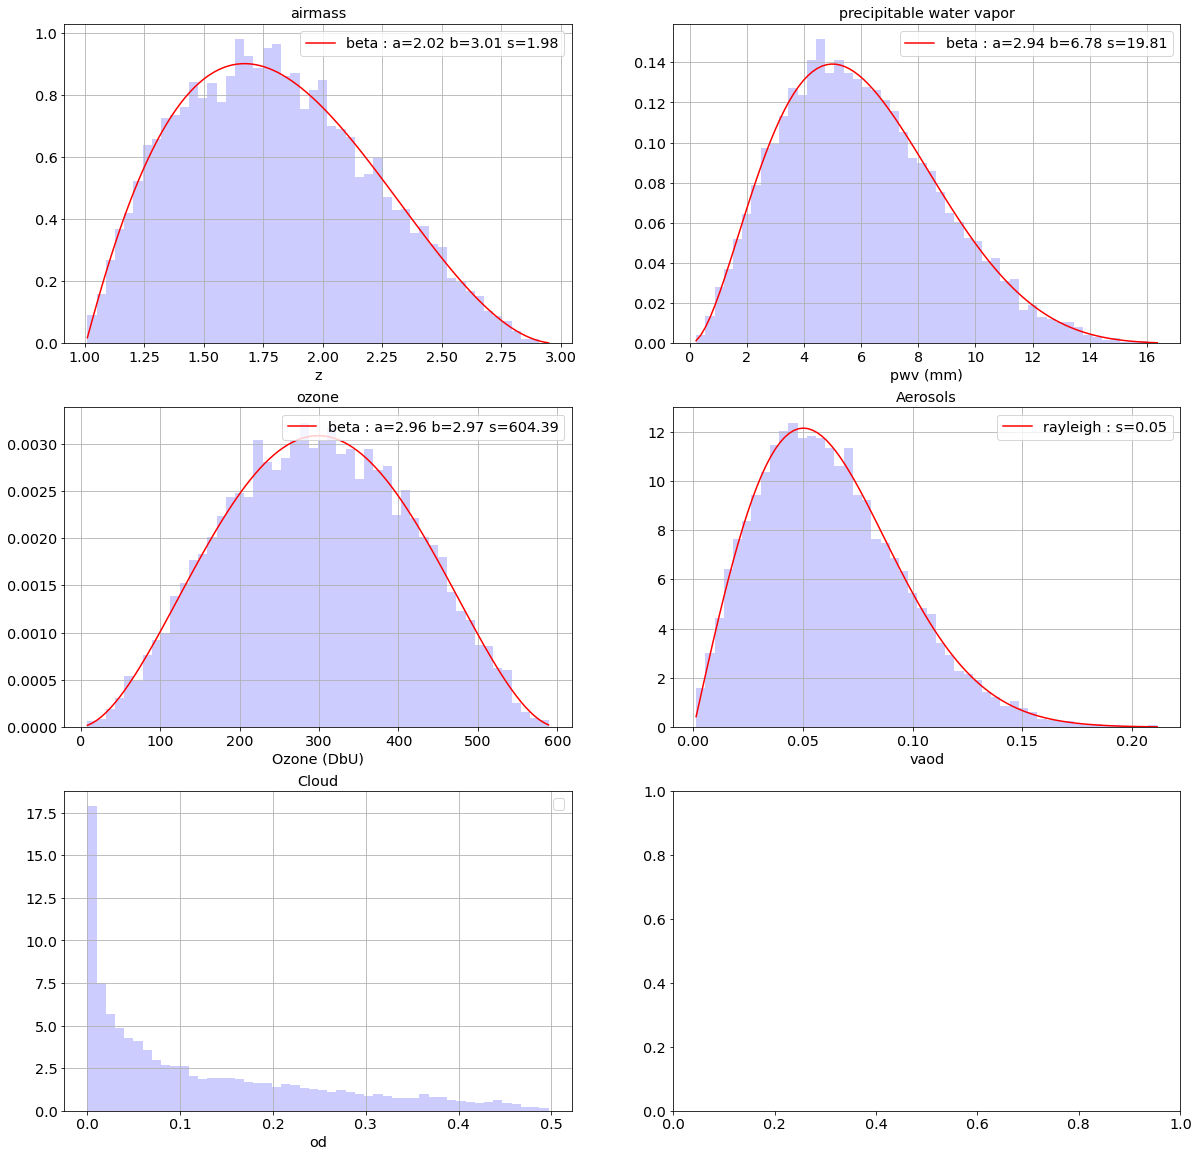

In [199]:
def GetDistribFromName(name):
    
    rayleigh,beta,gamma,uniform
    
    if name=="rayleigh":
        return rayleigh
    elif name=="beta":
        return beta
    elif name=="gamma":
        return gamma
    else:
        return uniform
    


if FLAG_PLOT:
    fig=plt.figure(figsize=(20,20))
    ax1=fig.add_subplot(321)
    ax2=fig.add_subplot(322)
    ax3=fig.add_subplot(323)
    ax4=fig.add_subplot(324)
    ax5=fig.add_subplot(325)
    ax6=fig.add_subplot(326)

    
    
    ax1.hist(airmass,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax1.set_title("airmass")
    ax1.set_xlabel("z")
    
    
    if 'AIRMASS' in config_section:
        distrib_name= config['AIRMASS']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(airmass)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(airmass.min(),airmass.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        ax1.plot(x,pdf,"r-",label=label)
        ax1.legend()
        ax1.grid()
    
    
    
    
    ax2.hist(pwv,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax2.set_title("precipitable water vapor")
    ax2.set_xlabel("pwv (mm)")
    
    if 'PWV' in config_section:
        distrib_name= config['PWV']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(pwv)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(pwv.min(),pwv.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax2.plot(x,pdf,"r-",label=label)
        ax2.legend()
        ax2.grid()
    
        
    
    ax3.hist(ozone,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax3.set_title("ozone")
    ax3.set_xlabel("Ozone (DbU)")
    
    if 'OZONE' in config_section:
        distrib_name= config['OZONE']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(ozone)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(ozone.min(),ozone.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : a={:2.2f} b={:2.2f} s={:2.2f}".format(arg[0],arg[1],scale)
        ax3.plot(x,pdf,"r-",label=label)
        ax3.legend()
        ax3.grid()
    
    
    
    ax4.hist(vaod,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax4.set_title("Aerosols")
    ax4.set_xlabel("vaod")
    
    
    if 'AEROSOL' in config_section:
        distrib_name= config['AEROSOL']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(vaod)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(vaod.min(),vaod.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        ax4.plot(x,pdf,"r-",label=label)
        ax4.legend()
        ax4.grid()
    
    
    
    ax5.hist(cld,bins=50,facecolor='blue',alpha=0.2,density=True);
    ax5.set_title("Cloud")
    ax5.set_xlabel("od")
    
    
    if 'CLOUD' in config_section:
        distrib_name= config['CLOUD']['distrib']
        distrib=GetDistribFromName(distrib_name)
        # fit dist to data
        params = distrib.fit(cld)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        x=np.linspace(cld.min(),cld.max(),100)
        pdf = distrib.pdf(x, loc=loc, scale=scale, *arg)
        #label=distrib_name + " : s={:2.2f}".format(scale)
        label=distrib_name + " : s={:2.2f}".format(scale)
        #ax5.plot(x,pdf,"r-",label=label)
        ax5.legend()
        ax5.grid()
    


### Select wavelength range

Truncate wavelength

In [45]:
WLMINSEL=340.
WLMAXSEL=1100.

In [46]:
indexes_selected=np.where(np.logical_and(wl>=WLMINSEL,wl<=WLMAXSEL))[0]

In [47]:
# need even number of bins
if len(indexes_selected)%2:
    indexes_selected=indexes_selected[:-1]

In [49]:
wl=wl[indexes_selected]
transm_tot=transm[:,indexes_selected]

### Remove rayleigh component

In [50]:
od_rayl=atm.RayOptDepth_adiabatic(wl, altitude=atm.altitude0, costh=1/1.2)
att_rayleigh=np.exp(-od_rayl)

In [51]:
transm=transm_tot/att_rayleigh

### Not removing the rayleigh

In [52]:
transm=transm_tot

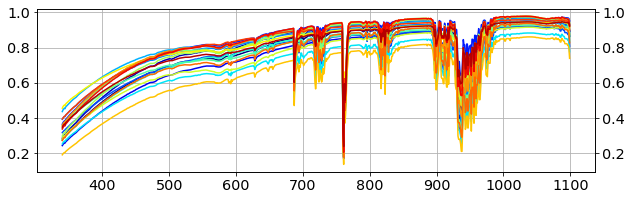

In [53]:
if FLAG_PLOT:
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,transm[idx,:],c=all_colors[idx])
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()

In [54]:
NWL=wl.shape[0]

In [55]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NWL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NWL), alpha=1)

# Prepare data : X and Y

In [97]:
airmassarr=airmass[:,np.newaxis]
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=ozone[:,np.newaxis]
cldarr=cld[:,np.newaxis]

## Clouds

## clouds in input data

In [71]:
transm_cloud=np.exp(-cld)
transm_cloud_arr=np.exp(-cldarr)

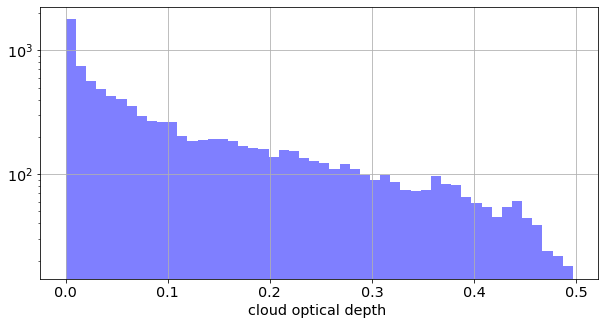

In [59]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,5))

    ax = fig.add_subplot(111)
    plt.hist(cld,bins=50,facecolor="b",label="in data",alpha=0.5)
    ax.set_yscale('log')
    ax.set_xlabel("cloud optical depth ")
    ax.grid()


### concatenate VAOD,PWV, Ozone

In [60]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)

### Use magnitudes for X

In [61]:
t=GetListOfCalspec()
t_sel=SelectFewSED(t)


In [62]:
t_sel

<Table length=8>
 OBJNAME     RA     DEC   SP_TYPE SP_QUAL ...  calcR   calcI    factor     VmI  
 bytes10  float64 float64 bytes12  bytes1 ... float64 float64  float64   float64
--------- ------- ------- ------- ------- ... ------- ------- ---------- -------
  NGC7293 337.411 -20.837   DAO.5       C ...  13.734  14.234      26.01  -0.697
   G93-48 328.106   2.389   DA2.8       C ...  12.836  13.234      12.34  -0.506
      HZ4  58.842   9.788   DA3.4       C ...  14.569  14.723     61.551  -0.250
ALPHA_LYR 279.235  38.784    A0Va       C ...   0.000  -0.004 0.00010079   0.013
 HD163466 268.106  60.396      A2       E ...   6.694   6.589   0.054409   0.251
 HD074000 130.212 -16.345      F2       D ...   9.269   8.987    0.72107   0.658
 HD106252 183.373  10.042      G0       E ...   6.957   6.653   0.091453   0.750
     FLAT   0.000   0.000    flat       0 ...   9.501   9.001          1   0.999

### Show examples of SED to use

2020-09-15 15:39:02,436 MacBook-Pro-de-admin.local astropy[56117] WARNING VerifyWarning: Invalid keyword for column 1: Column disp option (TDISPn) failed verification: Format 26A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-15 15:39:02,440 MacBook-Pro-de-admin.local astropy[56117] WARNING VerifyWarning: Invalid keyword for column 2: Column disp option (TDISPn) failed verification: Format 18A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-15 15:39:02,445 MacBook-Pro-de-admin.local astropy[56117] WARNING VerifyWarning: Invalid keyword for column 3: Column disp option (TDISPn) failed verification: Format 56A is not recognized. The invalid value will be ignored for the purpose of formatting the data in this column.
2020-09-15 15:39:02,448 MacBook-Pro-de-admin.local astropy[56117] WARNING VerifyWarning: Invalid keyword for column 4: Column disp option (

Warning, 44 of 7210 bins contained negative fluxes; they have been set to zero.
Warning, 19 of 6265 bins contained negative fluxes; they have been set to zero.


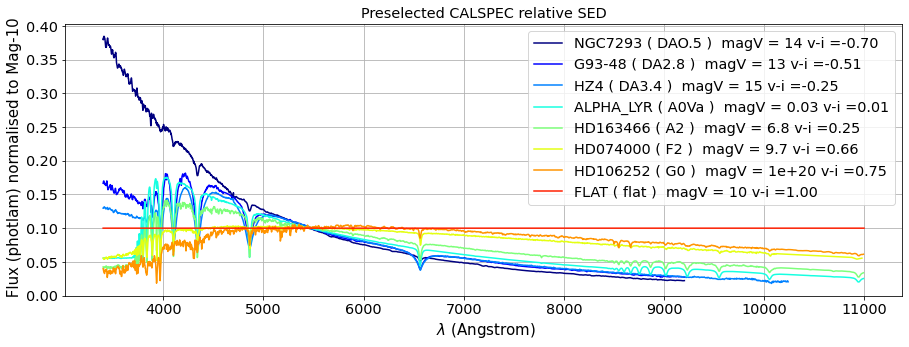

In [63]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(111)
    plot_sed(t_sel,ax)
    plt.show()

### Get the Spectrum

In [64]:
idx_sed_sel=3
sed_filename=t_sel[idx_sed_sel]["FILES"]
sed_objname=t_sel[idx_sed_sel]["OBJNAME"]
sed_fullfilename=os.path.join(path_sed_calspec,sed_filename)
order2=True
if order2:
    specarrayfile="spec_"+sed_objname+"_ord12.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1 and 2"
    title_spec2="spectra order 2"
else:
    specarrayfile="spec_"+sed_objname+"_ord1.npy"
    specarrayfile2="spec2_"+sed_objname+"_ord2.npy"
    title_spec1="spectra order 1"
    title_spec2="spectra order 2"

In [65]:
specarrayfile

'spec_ALPHA_LYR_ord12.npy'

In [66]:
specarrayfile2

'spec2_ALPHA_LYR_ord2.npy'

In [67]:
if sed_filename=="flat":
    flatsp = S.FlatSpectrum(10, fluxunits='photlam')
    spec=flatsp
else:
    spec=S.FileSpectrum(sed_fullfilename)
        
spec_norm = spec.renorm(10, 'vegamag', S.ObsBandpass('johnson,v'))
    
spec_norm.convert('photlam')

In [68]:
if not os.path.isfile(specarrayfile) or not os.path.isfile(specarrayfile2) :
    spectra,spectra2=GetSpectra(sed=spec_norm,wl_atm=wl,atm_transmission=transm,order2=order2)
    np.save(specarrayfile,spectra)
    np.save(specarrayfile2,spectra2)   
else:
    spectra=np.load(specarrayfile)
    spectra2=np.load(specarrayfile2)

2020-09-15 15:40:19,366 MacBook-Pro-de-admin.local numexpr.utils[56117] INFO NumExpr defaulting to 8 threads.


(((QE * atm0) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm0) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be us

(((QE * atm46) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm47) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm47) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm48) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm48) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm49) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm49) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm50) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm86) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm87) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm87) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm88) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm88) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm89) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm89) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm90) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum wi

(((QE * atm127) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm128) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm128) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm129) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm129) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm130) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm130) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm131) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm174) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm174) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm175) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm175) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm176) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm176) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm177) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm177) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm221) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm221) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm222) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm222) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm223) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm223) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm224) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm224) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm254) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm255) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm255) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm256) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm256) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm257) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm258) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm300) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm300) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm301) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm302) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm302) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm303) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm303) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm346) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm346) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm347) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm347) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm348) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm348) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm349) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm391) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm391) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm392) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm392) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm393) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm393) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm394) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm434) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm435) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm435) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm436) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm436) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm437) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm437) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm438) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm478) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm478) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm479) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm479) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm480) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm480) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm481) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm481) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm524) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm524) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm525) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm525) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm526) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm526) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm527) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm527) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm569) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm569) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm570) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm570) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm571) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm571) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm572) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm572) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm615) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm616) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm616) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm617) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm617) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm618) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm618) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm619) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm662) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm663) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm663) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm664) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm664) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm665) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm665) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm666) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm709) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm709) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm710) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm710) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm711) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm711) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm712) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm712) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm751) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm752) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm752) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm753) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm753) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm754) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm754) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm755) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm789) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm791) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm791) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm792) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm792) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm793) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm830) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm830) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm831) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm831) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm832) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm832) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm833) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm833) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm874) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm874) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm875) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm875) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm876) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm876) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm877) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm877) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm919) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm919) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm920) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm920) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm921) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm921) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm922) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm922) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm965) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm965) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm966) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm966) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm967) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm967) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm968) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm968) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spe

(((QE * atm1011) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1013) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1013) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1014) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1014) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1055) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1056) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1056) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1057) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1057) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1058) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1059) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1099) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1099) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1100) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1100) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1101) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1101) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1102) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1102) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1144) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1144) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1145) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1145) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1146) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1146) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1147) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1147) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1186) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1186) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1187) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1187) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1188) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1188) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1189) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1189) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1233) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1233) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1234) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1234) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1235) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1235) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1236) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1236) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1274) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1274) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1275) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1275) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1276) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1276) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1277) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1277) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1311) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1312) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1312) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1313) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1313) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1314) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1314) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1315) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1351) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1352) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1352) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1353) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1353) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1354) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1354) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1355) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1393) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1394) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1394) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1395) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1395) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1396) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1396) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1397) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1439) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1440) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1440) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1441) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1441) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1442) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1442) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1443) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1512) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1512) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1513) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1513) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1514) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1514) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1515) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1515) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1557) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1558) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1558) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1559) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1559) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1560) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1560) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1561) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1602) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1602) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1603) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1604) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1604) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1605) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1605) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1647) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1648) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1648) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1649) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1649) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1650) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1650) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1651) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1693) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1693) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1694) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1694) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1695) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1695) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1696) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1696) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1737) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1737) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1738) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1738) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1739) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1739) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1740) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1740) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1783) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1783) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1784) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1784) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1785) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1785) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1786) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1786) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1829) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1829) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1830) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1830) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1831) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1831) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1832) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1832) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1873) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1874) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1874) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1875) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1875) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1876) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1876) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1877) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1919) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1919) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1920) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1920) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1921) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1921) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1922) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1922) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm1964) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1964) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1965) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1965) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1966) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1966) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1967) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm1967) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2009) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2010) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2010) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2011) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2011) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2012) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2012) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2013) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2055) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2055) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2056) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2056) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2057) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2057) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2058) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2058) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2101) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2101) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2102) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2102) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2103) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2103) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2104) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2104) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2145) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2145) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2146) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2146) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2147) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2147) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2148) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2148) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2188) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2189) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2189) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2190) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2190) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2191) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2191) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2192) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2234) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2234) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2235) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2235) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2236) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2236) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2237) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2237) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2277) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2277) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2278) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2278) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2279) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2279) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2280) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2280) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2320) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2320) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2321) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2321) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2322) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2322) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2323) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2323) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2364) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2364) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2365) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2365) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2366) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2366) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2367) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2367) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2407) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2408) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2408) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2409) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2409) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2410) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2410) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2411) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2452) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2453) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2453) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2454) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2454) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2455) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2455) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2456) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2497) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2497) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2498) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2498) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2499) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2499) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2500) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2500) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2542) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2543) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2543) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2544) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2544) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2545) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2545) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2546) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2587) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2588) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2588) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2589) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2589) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2590) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2590) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2591) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2632) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2632) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2633) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2633) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2634) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2634) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2635) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2635) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2677) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2678) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2678) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2679) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2679) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2680) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2680) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2681) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2722) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2722) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2723) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2723) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2724) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2724) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2725) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2725) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2769) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2769) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2770) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2770) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2771) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2771) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2814) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2814) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2815) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2815) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2816) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2816) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2817) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2817) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2860) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2861) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2861) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2862) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2862) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2863) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2863) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2864) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2906) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2907) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2907) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2908) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2908) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2909) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2909) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2910) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm2951) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2952) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2952) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2953) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2953) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2954) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2954) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm2955) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3017) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3018) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3018) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3019) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3019) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3020) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3020) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3021) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3061) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3062) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3062) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3063) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3063) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3064) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3064) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3065) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3102) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3103) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3103) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3104) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3104) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3105) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3105) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3106) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3148) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3149) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3149) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3150) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3150) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3151) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3151) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3152) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3193) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3193) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3194) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3194) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3195) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3195) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3196) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3196) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3238) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3239) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3239) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3240) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3240) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3241) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3241) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3242) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3283) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3284) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3284) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3285) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3285) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3286) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3286) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3287) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3327) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3327) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3328) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3328) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3329) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3329) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3330) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3330) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3370) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3370) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3371) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3371) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3372) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3372) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3373) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3373) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3412) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3412) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3413) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3413) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3414) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3414) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3415) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3415) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3456) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3457) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3457) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3458) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3458) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3459) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3459) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3460) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3502) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3502) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3503) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3503) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3504) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3504) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3505) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3505) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3546) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3546) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3547) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3547) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3548) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3548) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3549) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3549) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3593) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3594) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3594) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3595) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3595) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3596) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3596) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3597) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3640) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3640) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3641) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3641) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3642) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3642) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3643) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3643) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3680) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3681) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3681) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3682) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3682) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3683) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3683) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3684) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3721) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3721) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3722) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3722) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3723) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3723) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3724) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3724) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3762) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3762) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3763) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3763) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3764) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3764) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3765) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3765) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3804) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3805) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3805) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3806) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3806) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3807) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3807) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3808) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3849) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3849) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3850) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3850) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3851) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3851) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3852) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3852) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3892) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3892) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3893) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3893) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3894) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3894) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3895) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3895) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3938) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3938) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3939) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3939) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3940) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3940) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3941) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3941) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm3981) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3981) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3982) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3982) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3983) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3983) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3984) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm3984) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4025) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4026) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4026) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4027) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4027) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4028) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4028) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4029) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4072) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4072) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4073) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4073) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4074) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4074) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4075) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4075) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4117) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4117) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4118) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4118) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4119) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4119) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4120) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4120) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4163) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4163) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4164) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4164) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4165) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4165) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4166) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4166) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4209) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4209) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4210) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4210) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4211) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4211) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4212) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4212) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4255) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4256) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4256) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4257) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4258) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4258) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4259) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4299) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4300) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4300) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4301) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4302) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4302) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4303) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4341) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4342) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4342) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4343) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4343) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4344) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4344) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4345) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4387) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4387) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4388) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4388) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4389) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4389) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4390) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4390) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4433) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4433) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4434) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4434) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4435) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4435) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4436) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4436) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4473) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4473) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4474) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4474) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4475) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4475) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4476) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4476) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4517) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4518) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4518) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4519) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4519) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4520) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4520) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4521) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4560) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4561) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4561) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4562) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4562) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4563) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4563) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4564) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4604) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4604) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4605) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4605) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4606) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4606) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4607) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4642) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4642) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4643) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4643) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4644) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4644) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4645) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4645) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4682) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4682) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4683) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4683) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4684) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4684) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4685) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4685) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4726) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4726) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4727) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4727) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4728) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4728) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4729) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4729) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4769) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4769) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4770) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4770) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4771) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4771) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4772) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4772) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4812) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4812) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4813) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4813) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4814) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4814) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4815) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4815) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4850) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4850) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4851) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4851) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4852) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4852) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4853) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4853) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4904) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4904) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4905) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4905) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4906) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4906) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4907) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4907) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4950) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4951) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4951) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4952) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4952) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4953) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4953) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4954) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm4996) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4996) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4997) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4997) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4998) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4998) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4999) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm4999) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5039) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5040) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5040) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5041) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5041) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5042) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5042) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5043) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5082) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5082) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5083) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5083) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5084) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5084) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5085) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5085) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5122) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5123) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5123) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5124) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5124) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5125) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5125) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5126) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5167) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5168) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5168) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5169) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5169) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5170) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5170) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5171) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5212) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5212) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5213) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5213) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5214) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5214) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5215) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5215) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5257) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5257) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5258) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5258) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5259) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5259) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5260) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5260) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5302) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5302) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5303) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5303) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5304) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5304) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5305) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5347) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5348) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5348) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5349) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5349) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5350) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5350) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5351) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5393) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5393) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5394) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5394) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5395) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5395) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5396) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5396) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5438) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5439) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5439) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5440) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5440) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5441) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5441) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5442) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5484) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5484) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5485) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5485) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5486) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5486) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5487) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5487) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5528) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5529) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5529) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5530) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5530) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5531) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5531) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5532) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5568) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5569) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5569) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5570) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5570) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5571) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5571) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5572) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5609) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5610) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5610) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5611) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5611) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5612) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5612) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5613) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5654) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5654) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5655) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5655) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5656) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5656) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5657) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5657) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5698) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5698) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5699) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5699) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5700) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5700) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5701) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5701) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5742) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5742) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5743) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5743) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5744) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5744) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5745) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5745) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5787) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5788) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5788) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5789) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5789) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5791) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5832) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5832) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5833) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5833) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5834) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5834) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5835) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5835) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5875) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5875) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5876) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5876) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5877) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5877) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5878) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5878) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5915) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5916) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5916) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5917) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5917) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5918) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5918) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5919) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm5960) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5961) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5961) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5962) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5962) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5963) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5963) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm5964) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6003) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6003) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6004) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6004) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6005) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6005) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6006) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6006) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6048) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6049) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6049) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6050) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6050) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6051) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6051) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6052) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6094) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6095) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6095) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6096) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6096) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6097) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6097) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6098) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6139) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6139) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6140) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6140) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6141) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6141) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6142) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6142) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6183) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6183) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6184) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6184) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6185) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6185) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6186) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6186) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6226) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6227) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6227) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6228) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6228) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6229) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6229) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6230) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6271) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6272) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6272) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6273) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6273) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6274) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6274) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6275) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6315) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6316) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6316) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6317) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6317) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6318) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6318) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6319) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6359) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6359) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6360) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6360) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6361) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6361) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6362) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6362) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6404) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6405) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6405) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6406) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6406) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6407) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6407) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6408) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6447) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6448) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6448) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6449) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6449) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6450) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6450) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6451) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6493) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6494) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6494) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6495) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6495) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6496) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6496) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6497) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6540) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6541) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6541) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6542) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6542) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6543) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6543) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6544) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6582) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6582) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6583) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6583) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6584) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6584) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6585) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6585) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6628) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6629) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6629) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6630) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6630) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6631) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6631) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6632) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6673) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6673) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6674) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6674) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6675) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6675) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6676) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6676) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6719) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6719) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6720) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6720) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6721) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6721) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6722) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6722) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6764) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6764) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6765) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6765) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6766) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6809) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6810) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6810) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6811) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6811) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6812) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6812) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6813) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6856) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6856) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6857) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6857) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6858) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6858) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6896) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6897) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6897) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6898) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6898) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6899) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6899) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6900) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6941) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6941) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6942) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6942) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6943) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6943) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6944) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6944) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm6985) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6986) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6986) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6987) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6987) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6988) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6988) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm6989) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7030) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7031) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7031) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7032) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7032) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7033) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7033) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7034) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7077) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7077) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7078) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7078) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7079) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7079) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7080) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7080) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7119) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7119) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7120) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7120) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7121) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7121) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7122) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7122) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7163) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7164) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7164) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7165) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7165) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7166) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7166) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7167) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7206) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7207) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7207) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7208) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7208) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7209) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7209) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7210) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7253) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7253) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7254) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7254) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7255) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7255) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7256) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7256) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7298) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7299) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7299) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7300) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7300) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7301) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7302) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7343) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7343) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7344) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7344) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7345) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7345) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7346) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7346) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7383) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7384) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7384) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7385) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7385) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7386) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7386) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7387) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7423) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7423) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7424) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7424) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7425) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7425) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7426) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7426) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7469) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7469) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7470) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7470) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7471) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7471) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7472) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7472) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7515) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7516) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7516) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7517) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7517) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7518) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7518) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7519) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7561) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7561) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7562) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7562) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7563) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7563) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7564) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7564) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7607) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7608) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7608) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7609) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7609) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7610) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7610) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7611) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7652) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7653) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7653) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7654) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7654) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7655) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7655) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7656) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7696) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7697) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7697) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7698) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7698) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7699) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7699) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7700) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7741) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7742) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7742) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7743) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7743) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7744) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7744) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7745) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7787) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7788) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7788) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7789) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7789) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7790) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7790) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7791) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7833) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7834) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7834) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7835) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7835) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7836) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7836) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7837) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7880) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7880) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7881) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7881) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7882) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7882) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7883) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7883) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7926) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7926) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7927) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7927) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7928) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7928) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7929) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7929) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm7971) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7972) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7972) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7973) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7973) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7974) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7974) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm7975) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8015) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8016) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8016) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8017) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8017) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8018) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8018) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8019) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8060) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8060) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8061) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8061) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8062) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8062) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8063) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8063) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8106) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8107) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8107) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8108) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8108) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8109) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8109) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8110) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8150) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8151) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8151) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8152) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8152) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8153) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8153) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8154) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8196) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8196) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8197) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8197) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8198) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8198) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8199) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8199) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8241) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8241) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8242) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8242) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8243) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8243) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8244) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8244) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8287) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8288) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8288) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8289) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8289) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8290) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8290) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8291) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8332) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8332) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8333) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8333) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8334) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8334) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8335) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8335) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8376) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8377) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8377) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8378) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8378) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8379) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8379) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8380) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8423) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8423) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8424) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8424) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8425) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8425) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8426) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8426) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8468) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8469) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8469) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8470) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8470) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8471) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8471) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8472) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8511) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8511) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8512) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8512) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8513) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8513) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8514) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8514) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8554) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8554) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8555) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8555) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8556) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8556) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8557) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8557) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8594) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8595) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8595) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8596) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8596) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8597) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8597) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8598) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8638) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8638) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8639) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8639) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8640) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8640) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8641) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8641) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8682) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8683) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8683) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8684) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8684) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8685) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8685) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8686) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8724) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8724) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8725) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8725) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8726) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8726) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8727) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8727) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8765) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8765) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8766) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8766) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8767) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8767) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8768) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8768) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8809) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8809) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8810) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8810) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8811) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8811) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8812) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8812) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8854) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8854) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8855) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8855) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8856) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8856) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8857) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8857) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8897) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8898) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8898) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8899) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8899) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8900) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8900) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8901) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8942) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8942) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8943) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8943) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8944) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8944) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8945) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8945) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm8985) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8986) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8986) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8987) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8987) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8988) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8988) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm8989) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9026) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9027) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9027) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9028) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9028) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9029) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9029) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9030) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9070) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9071) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9071) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9072) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9072) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9073) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9073) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9074) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9113) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9113) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9114) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9114) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9115) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9115) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9116) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9116) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9159) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9160) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9160) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9161) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9161) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9162) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9162) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9163) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9205) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9205) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9206) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9206) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9207) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9207) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9208) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9208) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9251) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9252) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9252) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9253) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9253) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9254) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9254) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9255) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9298) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9298) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9299) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9299) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9300) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9300) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9301) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9301) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9343) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9343) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9344) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9344) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9345) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9345) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9346) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9346) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9386) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9387) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9387) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9388) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9388) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9389) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9389) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9390) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9429) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9430) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9430) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9431) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9431) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9432) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9432) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9433) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9468) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9468) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9469) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9469) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9470) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9470) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9471) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9471) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9511) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9512) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9512) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9513) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9513) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9514) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9514) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9515) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9555) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9556) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9556) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9557) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9557) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9558) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9558) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9559) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9600) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9600) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9601) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9601) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9602) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9602) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9603) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9603) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9642) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9643) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9643) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9644) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9644) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9645) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9645) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9646) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9687) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9687) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9688) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9688) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9689) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9689) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9690) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9690) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9732) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9732) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9733) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9733) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9734) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9734) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9735) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9735) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9774) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9775) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9775) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9776) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9776) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9777) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9777) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9778) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9817) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9817) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9818) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9818) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9819) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9819) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9820) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9820) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9861) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9861) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9862) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9862) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9863) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9863) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9864) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9864) * Holo2)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9903) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9904) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9904) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9905) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9905) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9906) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9906) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9907) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9948) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9949) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9949) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9950) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9950) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9951) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9951) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9952) * Holo)) does not have a defined binset in the wavecat table. The waveset of

(((QE * atm9994) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9995) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9995) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9996) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9996) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9997) * Holo)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9997) * Holo2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(((QE * atm9998) * Holo)) does not have a defined binset in the wavecat table. The waveset of

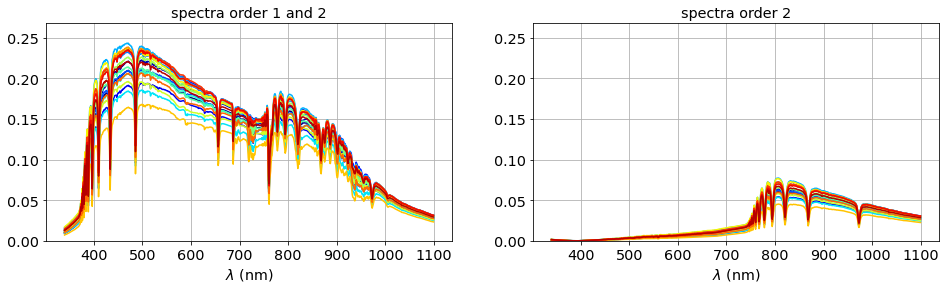

In [96]:
if FLAG_PLOT:
    
    N=20
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    themax=0
    themin=0
    
    fig=plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    for idx in np.arange(N):
        if spectra[idx,:].max()>themax:
            themax=spectra[idx,:].max()
        ax.plot(wl,spectra[idx,:],color=all_colors[idx])
    ax.set_ylim(0,1.1*themax)
    ax.grid()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_title(title_spec1)
    
    ax = fig.add_subplot(122)
    for idx in np.arange(N):
        ax.plot(wl,spectra2[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylim(0,1.1*themax)
    ax.set_title(title_spec2)
    ax.grid()

In [100]:
FLAG_MAG=True
if FLAG_MAG:
    X=-2.5*np.log10(spectra*transm_cloud_arr)/airmassarr
else:
    X=spectra*transm_cloud_arr

In [140]:
X.shape

(10000, 760)

### Check transmission or spectrum

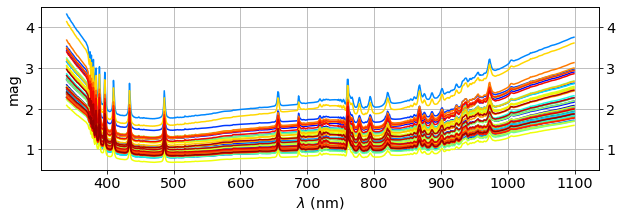

In [101]:
if FLAG_PLOT:
    N=50
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    for idx in np.arange(N):
        ax.plot(wl,X[idx,:],color=all_colors[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("mag")
    ax.grid()
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())

## Splitting

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [103]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [104]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [105]:
FLAG_SCALING=True

In [106]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [107]:
scaler_X.mean_.shape

(760,)

In [108]:
scaler_X.scale_.shape

(760,)

In [109]:
scaler_Y.mean_.shape

(4,)

In [110]:
scaler_Y.scale_.shape

(4,)

In [111]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

In [143]:
X_train_scaled.shape

(6000, 760)

In [145]:
X_val_scaled.shape 

(2000, 760)

In [146]:
X_test_scaled.shape 

(2000, 760)

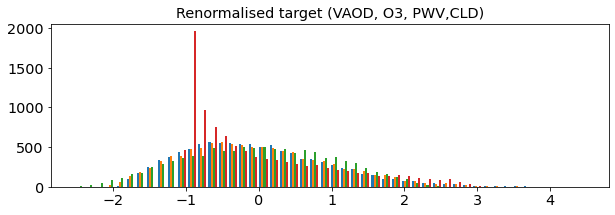

In [147]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50)
    ax.set_title("Renormalised target (VAOD, O3, PWV,CLD)")

## Linear regression model

In [148]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [149]:
reg = linear_model.LinearRegression()

In [115]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [152]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[-6.31529695e+02  1.17337628e+02  8.19779208e+02 ... -4.49001885e+05
   1.09676017e+05 -1.27756663e+04]
 [ 2.06194860e-02  5.72690164e-01 -1.15078124e+00 ... -8.56526336e+03
   1.77498025e+03 -1.61567858e+02]
 [ 2.91772102e+00 -2.69257666e+00 -2.69432752e+00 ...  2.10798550e+03
  -5.73812560e+02  6.58478515e+01]
 [ 4.40616721e+04 -4.95804333e+04  2.63725351e+04 ...  4.64075341e+07
  -1.08933579e+07  1.15289951e+06]]
Mean squared error: 0.01477
Coefficient of determination: 0.98557
Explained variance: 0.98560


In [153]:
X_train_scaled.shape

(6000, 760)

In [154]:
regr.coef_.shape

(4, 760)

# Linear Regression with Ridge

In [155]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [156]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[-1.42236557 -0.56178103 -0.16824422 ...  3.34940563  3.53134647
   3.79811444]
 [ 0.15686378  0.11537433  0.09508046 ... -0.2593112  -0.2821734
  -0.32077686]
 [ 1.2826023   0.57819831  0.28958391 ... -0.04632125 -0.0625909
  -0.08378619]
 [ 1.1220486   0.40420746  0.85321383 ... -2.35765386 -2.6636005
  -2.38792361]]
Mean squared error: 0.01277
Coefficient of determination: 0.98752
Explained variance: 0.98754


In [157]:
regr_ridge.coef_.shape

(4, 760)

## Tune hyper parameter with Ridge

In [119]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.4548e-19): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.2844e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.85547e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.65461e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.57139e-18): result may not be accurate.
  overwrite_a=True).T
/Users/dagor

<Figure size 1080x1080 with 0 Axes>

In [158]:
allcoefs.shape

(20, 4, 760)

In [120]:
RIDGE_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [121]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [122]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

0.0017225859653987874

0.0017225859653987874

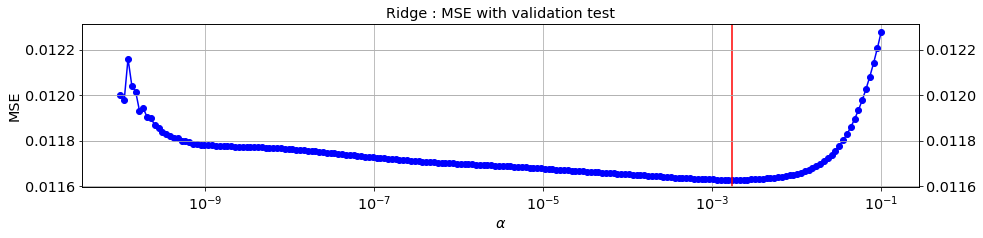

In [124]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
#if FLAG_MAG:
#    idx_min=np.where(all_MSE<1e-6)[0][-1]
#else:
#    idx_min=np.where(all_MSE<1e-6)[0][-1]
alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

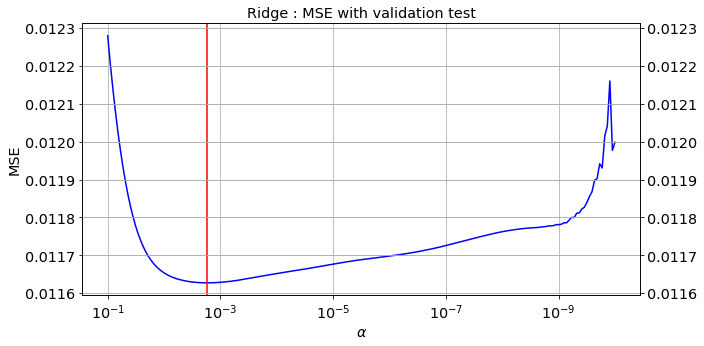

In [125]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
ax.grid()
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [142]:
allcoefs.shape

(20, 4, 760)

In [159]:
N=NWL
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

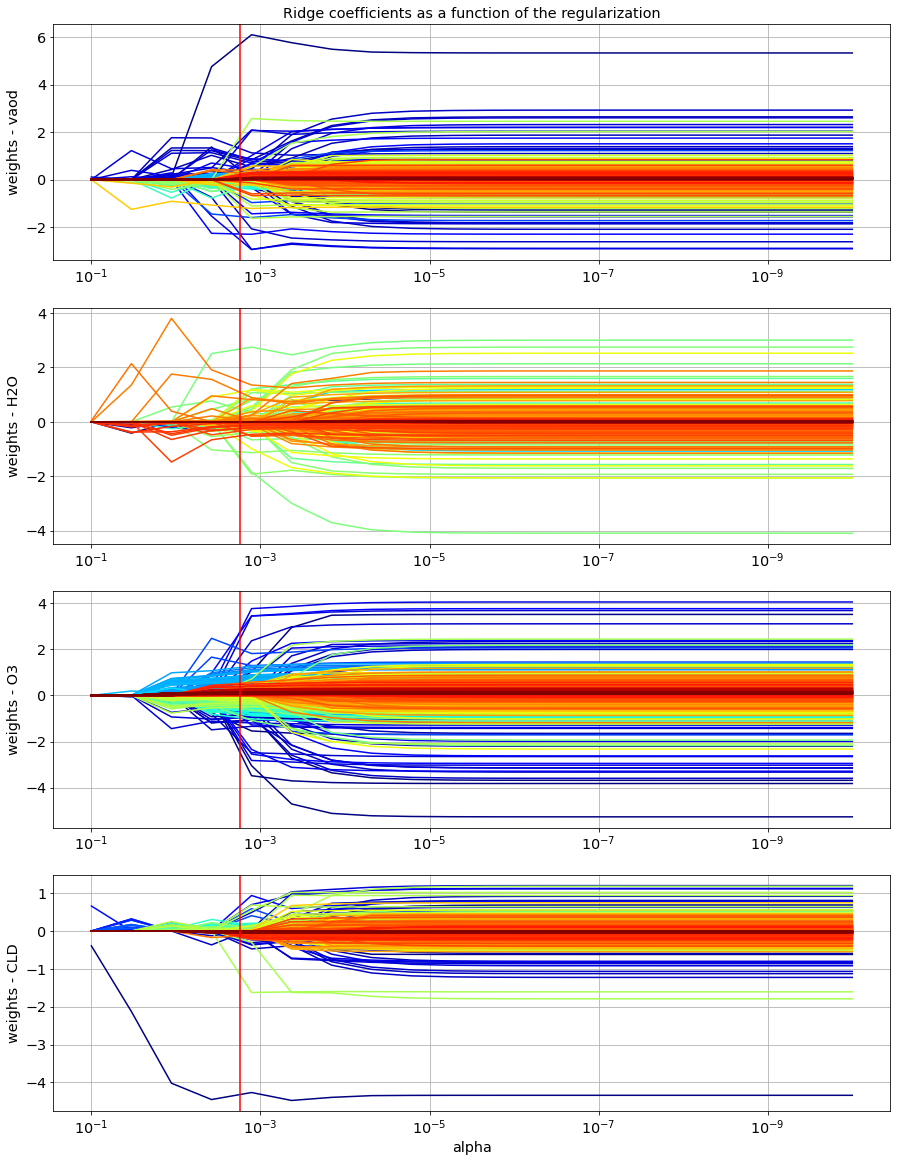

In [160]:
fig=plt.figure(figsize=(15,20))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.axvline(x=alpha_ridge,color='red')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.set_title('Ridge coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.axvline(x=alpha_ridge,color='red')
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.axvline(x=alpha_ridge,color='red')
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.axvline(x=alpha_ridge,color='red')
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)


plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [127]:
from sklearn import linear_model

In [128]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [129]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439.0706688170684, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.72056201158361, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1541.5352572512172, tolerance: 0.6000000000000036
  positive)


Coefficients: 
 [[ 5.34071605e+00 -1.34817918e+00 -5.86726240e-01 ...  5.09668789e-03
   1.21114915e-02  3.89822792e-02]
 [ 9.30788337e-01 -3.05085213e-02 -1.58448866e-02 ... -2.21858632e-03
  -0.00000000e+00  2.95996185e-02]
 [-5.25246062e+00 -3.81497956e+00 -1.68728953e+00 ...  4.78189888e-02
   5.98172289e-02  9.12428072e-02]
 [-4.33957717e+00  6.67869690e-01  2.97376119e-01 ... -4.38670019e-03
  -7.38285030e-03 -1.82395723e-02]]
Mean squared error: 0.18781
Coefficient of determination: 0.80533
Explained variance: 0.80538


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.3960306959504, tolerance: 0.5999999999999999
  positive)


In [130]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.6558839048316, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.07701061366308, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528.3136737963412, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528.3170884849835, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 275.9360778935738, tolerance: 0.5999999999999996
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.6625193992223, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 430.83294682110784, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.21897332661653, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1528.5919679708052, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1549.5350182046361, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 283.0383404129756, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444.22043869285346, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 882.106106316184, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223.46648604087903, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2092.2837410264974, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

<Figure size 1080x1080 with 0 Axes>

In [ ]:
LASSO_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

In [ ]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [132]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

0.003792690190732246

0.003792690190732246

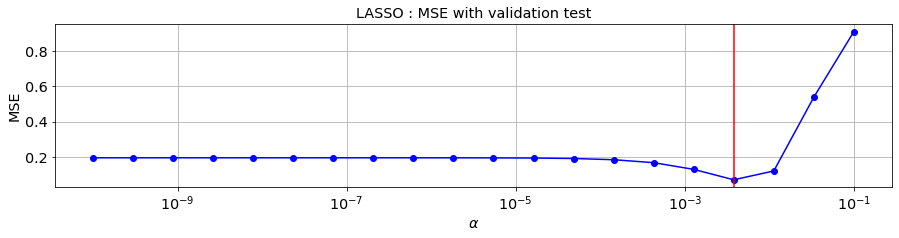

In [133]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")
if FLAG_MAG:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
else:
    idx_min=np.where(all_MSE==all_MSE.min())[0][0]
alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
alpha_lasso

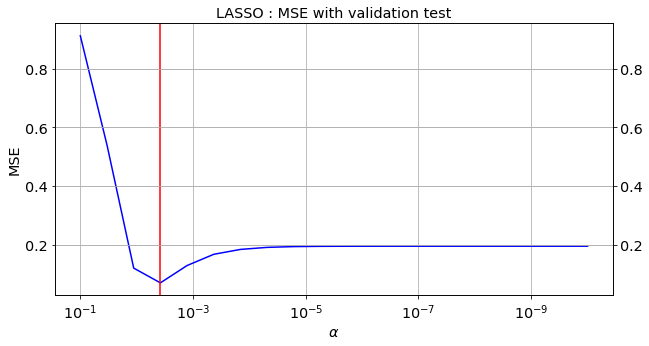

In [134]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

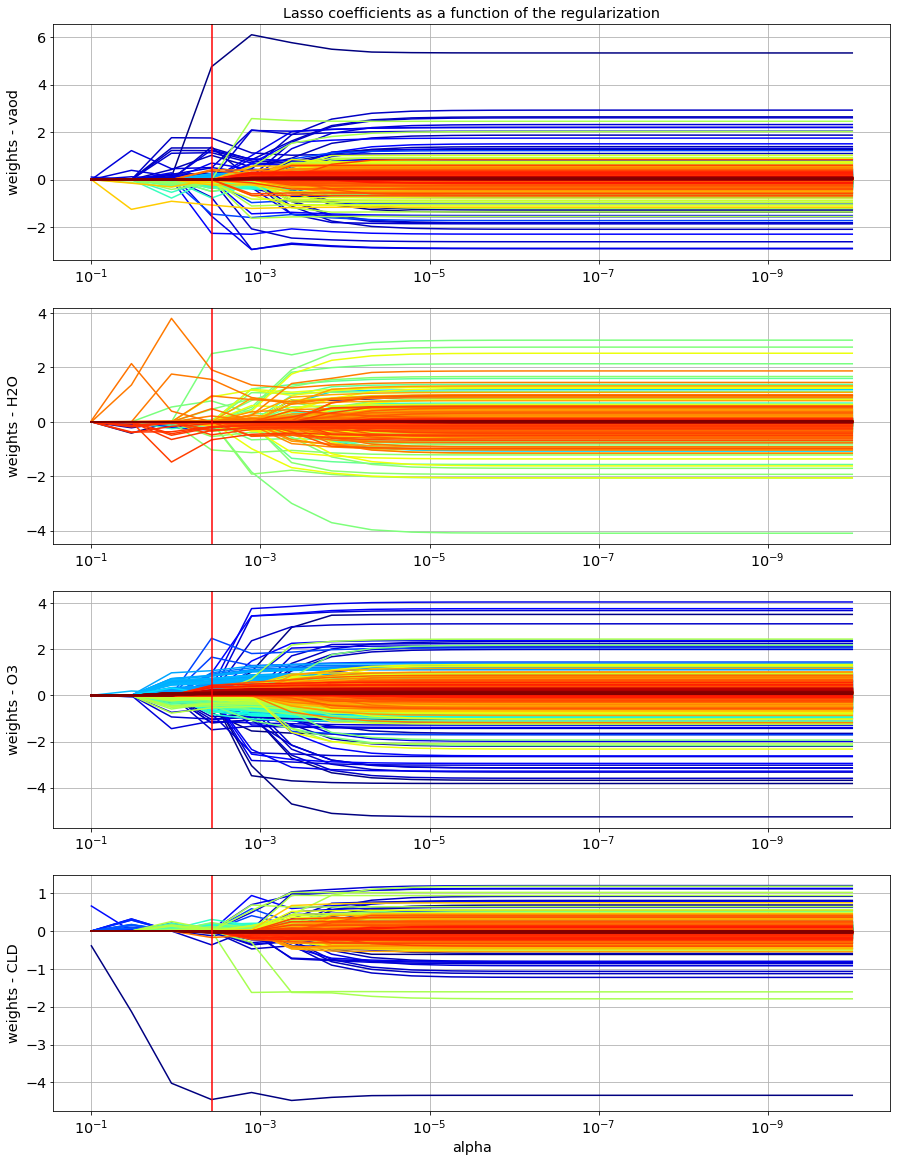

In [161]:
N=NWL
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

fig=plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.axvline(x=alpha_lasso,color='red')
ax1.grid(True)
ax1.set_title('Lasso coefficients as a function of the regularization')

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.axvline(x=alpha_lasso,color='red')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.axvline(x=alpha_lasso,color='red')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.axvline(x=alpha_lasso,color='red')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.grid(True)

plt.xlabel('alpha')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [162]:
nb_tot_test=len(Y_test)
nb_tot_train=len(Y_train)

In [163]:
nsamples_test=np.arange(10,nb_tot_test,100)
nsamples_train=np.arange(10,nb_tot_train,100)

### Leraning curves for linear regression

In [164]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [165]:
count=0
for n in nsamples_train:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    # does the fit    
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    if n in nsamples_test:
        Y_pred_test  = regr.predict(X_test_cut)
        
    if FLAG_SCALING:     
        Y_pred_test_full = regr.predict(np.copy(X_test_scaled))
    else:
        Y_pred_test_full = regr.predict(np.copy(X_test))
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)
        
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
         MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full) 
            
    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
        
    
    count+=1
    # end of loop
    

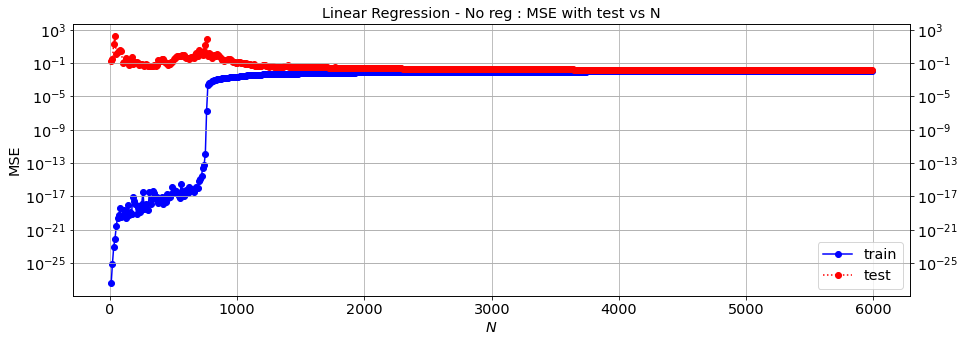

In [166]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r:o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [167]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [168]:
count=0
for n in nsamples_train:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = ridge.predict(X_test_scaled)
    else:
        Y_pred_test_full = ridge.predict(X_test)
        
        
    if n in nsamples_test:
        Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

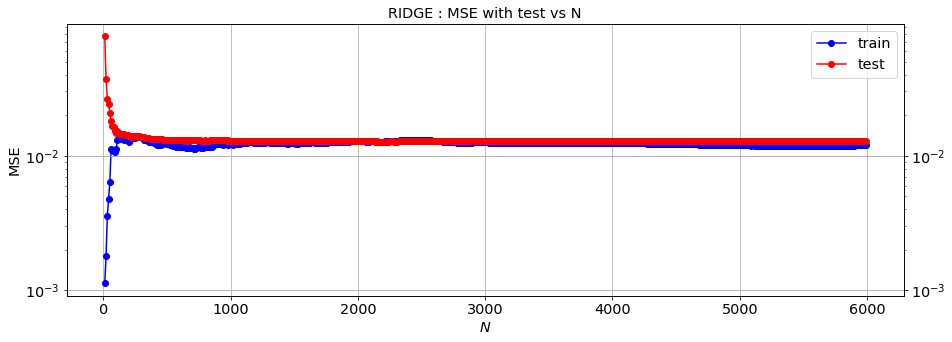

In [169]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N")
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [170]:
all_MSE_train=np.zeros(len(nsamples_train))
all_MSE_test=np.zeros(len(nsamples_test))
all_MSE_test_full=np.zeros(len(nsamples_train))

In [171]:
alpha_lasso

0.003792690190732246

In [172]:
alpha_lasso_min

0.003792690190732246

In [173]:
alpha_lasso_0=1e-3

In [174]:
count=0
for n in nsamples_train:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        if n in nsamples_test:
            X_test_cut=np.copy(X_test_scaled[:n,:])
            Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        if n in nsamples_test:
            X_test_cut=X_test[:n,:]
            Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    
    if FLAG_SCALING:  
        Y_pred_test_full = lasso.predict(X_test_scaled)
    else:
        Y_pred_test_full = lasso.predict(X_test)
    
    if n in nsamples_test:
        Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    
    
    
    if FLAG_SCALING:    
        MSE_test_full=mean_squared_error(Y_test_scaled, Y_pred_test_full) 
    else:
        MSE_test_full=mean_squared_error(Y_test, Y_pred_test_full)   
    
    if n in nsamples_test:
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test_full[count]=MSE_test_full
    
    if n in nsamples_test:
        all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49748500010286145, tolerance: 0.00028823314641822026
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2138388937806952, tolerance: 0.0003931938995739484
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.013188291991334, tolerance: 0.0007846834125749547
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You mi

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.888670966302927, tolerance: 0.008423743766641935
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.123374384099677, tolerance: 0.009542053100035341
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.26152293291037, tolerance: 0.00808421297258393
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.187299695094787, tolerance: 0.01427798404265287
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.10198479679633, tolerance: 0.017152846489905938
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.572377404131934, tolerance: 0.017908823870400825
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.05321205464011, tolerance: 0.023719004767410283
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.47830227812794, tolerance: 0.0243898822614614
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.1135247786957, tolerance: 0.025510123906075707
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 112.34929448796102, tolerance: 0.032596745574037744
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.913851897539026, tolerance: 0.03305027235287771
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.255239492349574, tolerance: 0.031238008122091276
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.82512517003696, tolerance: 0.03998694617908405
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.356065997891653, tolerance: 0.038522224242054405
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137.98207816911008, tolerance: 0.04054388551918297
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.01352165458366, tolerance: 0.04869512535116999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.32487591494847, tolerance: 0.04608412079675976
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.86965863637224, tolerance: 0.048204432532886546
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.10815096732429, tolerance: 0.05329708756184635
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.31363725637319, tolerance: 0.05111105897394054
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.6749996146093, tolerance: 0.05571182178019397
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216.6682605651938, tolerance: 0.06331174584124885
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.80405540611258, tolerance: 0.06136847607771561
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.52010208236916, tolerance: 0.062235708789584614
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.55850965788918, tolerance: 0.06726355602945334
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.18701328197509, tolerance: 0.07011128382262044
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245.0790473142915, tolerance: 0.07153086655140885
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265.58021310087685, tolerance: 0.0778664544964905
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.430049916525164, tolerance: 0.07578760589802759
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.65845223843874, tolerance: 0.07513425130627395
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.15564406452634, tolerance: 0.08030197164899579
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.973903244162113, tolerance: 0.08375393925374008
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 296.66334049279425, tolerance: 0.08639303667283285
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 321.3417112491019, tolerance: 0.09340929627846341
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.634366343594834, tolerance: 0.0920371934106543
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.9066831938099, tolerance: 0.08700303536148501
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133.76859134287412, tolerance: 0.09445608954834327
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.559851881364196, tolerance: 0.0969404723118207
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346.58306448130315, tolerance: 0.10141163810072203
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 370.8871810011277, tolerance: 0.10891149554866825
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.71256954168135, tolerance: 0.10715839778872258
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.85112767567085, tolerance: 0.10170858253500244
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 155.32063162629333, tolerance: 0.10939002259735207
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.57876542391007, tolerance: 0.11039118565218337
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 401.8021607407459, tolerance: 0.1179588284114523
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431.09597351099114, tolerance: 0.12684107461715194
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.0664672887456, tolerance: 0.12438591104676239
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167.7869549707848, tolerance: 0.11918982185677238
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.59344569996108, tolerance: 0.12392644272099425
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.2769932643007, tolerance: 0.12416852404477709
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453.8738233769296, tolerance: 0.1349350024813869
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477.5522189714436, tolerance: 0.14155875858558453
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89.33612309763855, tolerance: 0.1397912781633507
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186.68688626218446, tolerance: 0.13089465955849078
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197.56273688819658, tolerance: 0.13832185779274467
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.66647773138136, tolerance: 0.1394208641644075
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505.21369595100725, tolerance: 0.14898415093027478
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532.1626699598144, tolerance: 0.1555529856031648
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.18484127218034, tolerance: 0.15340906224645487
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210.07042736322092, tolerance: 0.14683143661481843
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.57518754954427, tolerance: 0.15205034432467168
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.155956792827375, tolerance: 0.15168740968058905
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560.3636214820597, tolerance: 0.16444090987730714
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 584.8596001953078, tolerance: 0.17166677209757605
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 109.49962472159183, tolerance: 0.1715737577951404
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.7270222631531, tolerance: 0.15960858445664228
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.84413205636042, tolerance: 0.1676176496579257
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.11367592107682, tolerance: 0.16503029835202732
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615.5668231160018, tolerance: 0.18095564087031163
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.0405177706843, tolerance: 0.18785953730762542
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.03779683926184, tolerance: 0.1874752123422476
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250.71571447400544, tolerance: 0.1774666575836289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260.49897668654364, tolerance: 0.18426834972017983
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.78778803890611, tolerance: 0.18027706877946548
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 665.0247605473503, tolerance: 0.19464263848814195
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.4190998486902, tolerance: 0.2020521353786422
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130.58423719014877, tolerance: 0.20507373507136137
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.02589681653103, tolerance: 0.19213432818735382
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279.357218685779, tolerance: 0.19723829200529255
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76.72950908513408, tolerance: 0.19754215439572814
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 718.2133781914806, tolerance: 0.21007554122027589
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 745.7890536598509, tolerance: 0.21864052665493375
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.22089000895534, tolerance: 0.219152654361273
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292.68748956234936, tolerance: 0.20554485996463406
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301.4442055805414, tolerance: 0.21199728771869342
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.01037247132732, tolerance: 0.21302903273403345
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.1367440104887, tolerance: 0.225426492959566
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 792.0303528066179, tolerance: 0.23103270808341828
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.33839899236946, tolerance: 0.2320044343539691
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 312.43030773155937, tolerance: 0.21978252552449212
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.77886297860493, tolerance: 0.22657846367324816
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88.89510851829328, tolerance: 0.2299593947500113
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 821.8066102163065, tolerance: 0.2384391068108676
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 844.0017057224152, tolerance: 0.24492219345992164
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.48177720829878, tolerance: 0.24974495670795055
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334.09626883103016, tolerance: 0.23536602771301304
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344.8134848960433, tolerance: 0.24326854862498012
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.68622944806333, tolerance: 0.2449080779707047
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872.4177739141198, tolerance: 0.2537662473817532
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 893.6710788820558, tolerance: 0.2597875631456239
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.08129477594085, tolerance: 0.26215001085776224
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 356.2181570517208, tolerance: 0.2521887939541656
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366.00718520789076, tolerance: 0.258223305067366
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.42239559277806, tolerance: 0.2610876914677713
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 921.717534204455, tolerance: 0.2677161264719137
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 952.3014843042156, tolerance: 0.27772426767021446
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 182.20669684192387, tolerance: 0.2743390721034037
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377.16565468396817, tolerance: 0.2671335329981402
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387.82520025534814, tolerance: 0.27579867819225695
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.58751538043855, tolerance: 0.27878149794028034
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 983.207646300512, tolerance: 0.286506229551197
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1010.9443579229273, tolerance: 0.2955376127936198
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190.75965442556563, tolerance: 0.28734698378844187
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397.8158018368636, tolerance: 0.28234443444132257
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406.87713418111935, tolerance: 0.2885429915001019
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111.87585560482614, tolerance: 0.2953637644819137
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1039.5374878338575, tolerance: 0.3037189876297162
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1061.7986650732576, tolerance: 0.3101091292964931
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.53507235145452, tolerance: 0.30178782854716607
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419.1966914462996, tolerance: 0.2971147214990114
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 427.80062348605077, tolerance: 0.3020332395913878
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117.46234145925462, tolerance: 0.31005138138807264
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1087.2400681573554, tolerance: 0.3174390071658267
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1112.9935103860262, tolerance: 0.32458028548199713
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209.34765242848403, tolerance: 0.3160309463030924
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 438.5439394417225, tolerance: 0.3111788950293064
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.05566954653773, tolerance: 0.3197707726897471
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.34217033139362, tolerance: 0.32484293539810755
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1145.501156611112, tolerance: 0.33396877072372183
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1161.8180172813227, tolerance: 0.3389397993434841
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219.48887118967676, tolerance: 0.3311229328217077
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459.9894823714418, tolerance: 0.3266815333524016
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.4203179198979, tolerance: 0.3334297426940669
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 129.58510227589775, tolerance: 0.34230146414317775
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1190.268732635273, tolerance: 0.3467984299924957
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1216.7794792103975, tolerance: 0.35463706657398497
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228.46555719612942, tolerance: 0.34799278452495297
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 480.5240350812052, tolerance: 0.340350474141172
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 490.5603568061206, tolerance: 0.34850689636390597
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.34598202209267, tolerance: 0.3556998369489913
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1244.9691055991493, tolerance: 0.3623483838935444
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1267.3425701170358, tolerance: 0.36926696910129697
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237.32220150479355, tolerance: 0.36178563645048245
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.3298152804777, tolerance: 0.3578474040462913
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510.8644025067852, tolerance: 0.3633227331880168
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139.62707335005175, tolerance: 0.37137864698964296
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1296.9228456248918, tolerance: 0.37717279713526985
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1320.8548097402188, tolerance: 0.3841283172370811
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246.27732327014252, tolerance: 0.3771375057450695
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 524.2702759654537, tolerance: 0.3740717734682595
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 533.9570677142721, tolerance: 0.37959706701945684
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.575605227189, tolerance: 0.38393433427690377
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1347.5955046085176, tolerance: 0.3915933350231663
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1373.2247496387777, tolerance: 0.39816720933461497
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257.5404931755087, tolerance: 0.3946312466039365
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.7261043799675, tolerance: 0.389759815233017
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.3011263192069, tolerance: 0.3971401145613102
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151.01837337323153, tolerance: 0.39954979846567523
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1401.5017777164726, tolerance: 0.4057899446959405
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1424.2412065403705, tolerance: 0.4131510479883662
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 266.52799565531404, tolerance: 0.41022541128701195
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567.5751410673139, tolerance: 0.40350418305491825
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 577.5870626841597, tolerance: 0.41356214005209385
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.48621200460548, tolerance: 0.41277716540016474
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1448.909701933575, tolerance: 0.42002802633165603
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1474.5140471409918, tolerance: 0.42839731588072094
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 276.28201065401134, tolerance: 0.42571051373343927
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.7249922378481, tolerance: 0.42368907731607314
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.7305171677638, tolerance: 0.4317550334209237
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163.03525409250113, tolerance: 0.4273778071251547
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1501.8054861218725, tolerance: 0.4362605612477004
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1526.0432375284581, tolerance: 0.44373228007980736
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 286.71140744614104, tolerance: 0.43831967884153783
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610.0758906879707, tolerance: 0.4407685132210427
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.7347308889392, tolerance: 0.44907791970358313
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168.2992343367016, tolerance: 0.44228312149903004
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1557.4328192452822, tolerance: 0.4528681765347932
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1579.8005110927013, tolerance: 0.4599756957808217
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297.02307914342424, tolerance: 0.45061960243823274
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.8670769935488, tolerance: 0.4576257212874369
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 642.6431005331863, tolerance: 0.46397739296255913
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.40198858220782, tolerance: 0.4569098787849182
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1603.7369091161374, tolerance: 0.4662444430327067
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1628.2468909580216, tolerance: 0.4727982993957523
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.1870088877077, tolerance: 0.4659602887024867
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653.2779116593995, tolerance: 0.47092063839922216
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.7085797739483, tolerance: 0.4782255805398805
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.44549711635557, tolerance: 0.4715304592072469
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1655.4570002842445, tolerance: 0.48121276581748684
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1675.4534699935493, tolerance: 0.4870263263806639
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.51893880704455, tolerance: 0.4788073817227285
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 673.6089949737534, tolerance: 0.48757487194353
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 682.2694058771358, tolerance: 0.49462372714504654
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183.6875147355545, tolerance: 0.4875365125347065
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1701.5540353861934, tolerance: 0.4950750611317859
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1727.205391105434, tolerance: 0.502638556917924
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 326.035517278475, tolerance: 0.4962702828202621
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693.7923582684073, tolerance: 0.5022847301182659
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to inc

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 702.942498054517, tolerance: 0.5088230844464197
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.85368363775447, tolerance: 0.5025223313958358
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1754.0508680642956, tolerance: 0.5101613372268725
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1772.6075576718952, tolerance: 0.5157240610474669
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 336.06112933951044, tolerance: 0.5116314847991352
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 714.2816361848165, tolerance: 0.5196948672626128
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 723.7626628361289, tolerance: 0.5264952914854479
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195.61308968487975, tolerance: 0.5173122243040299
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1797.9195884043525, tolerance: 0.5231692688862655
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1821.0315539297485, tolerance: 0.5305107690469711
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.42915877481914, tolerance: 0.5259199689145098
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.6952826730587, tolerance: 0.5335413037731178
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 742.3195469030729, tolerance: 0.5384214144559616
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200.50036055049068, tolerance: 0.5334868875557716
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1848.326183335973, tolerance: 0.5393438177399937
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1871.1257267366957, tolerance: 0.5453944847177753
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353.7713216624146, tolerance: 0.5399950537859249
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 752.424759250905, tolerance: 0.5458453621782127
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 762.2081228503628, tolerance: 0.5524490223446575
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205.7101712356344, tolerance: 0.5473750876216609
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1897.8383069609195, tolerance: 0.5532055516169905
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1919.462083255028, tolerance: 0.5591753357938009
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365.01055155579434, tolerance: 0.5545513287453528
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 773.7501622232866, tolerance: 0.5596495355626967
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 783.9639093291934, tolerance: 0.5674901743491771
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212.32485465017248, tolerance: 0.5649105300323172
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1949.1876536606678, tolerance: 0.5673952687984696
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1969.9716996418401, tolerance: 0.5734283449067319
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 374.16740707234226, tolerance: 0.568428021369701
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 794.4143011166848, tolerance: 0.5742422666292596
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 803.6196338274311, tolerance: 0.5816529677112127
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218.02907620736954, tolerance: 0.579180970300133
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1991.3291634882698, tolerance: 0.5795197172924011
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2016.533649702419, tolerance: 0.586603715348256
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 383.94216397777393, tolerance: 0.5861220670120096
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 814.0163982670133, tolerance: 0.5878303366068178
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to i

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 824.1551865010267, tolerance: 0.5941650020192762
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224.34494328675814, tolerance: 0.5937773493133568
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2047.3368570259545, tolerance: 0.5954813775230016
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

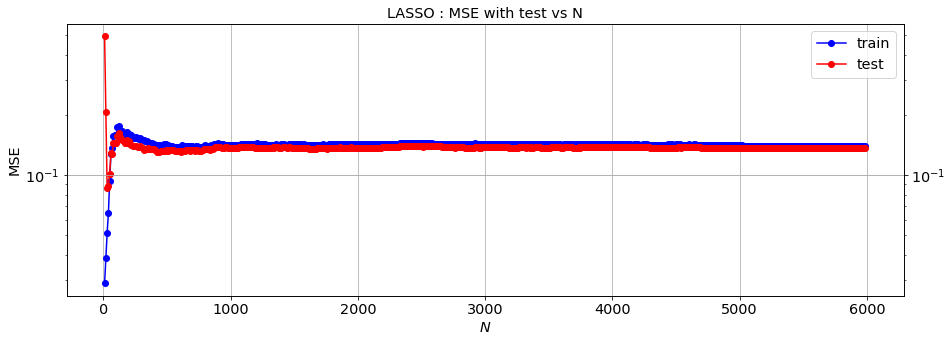

In [175]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples_train, all_MSE_train,'b-o',label="train")
#ax.plot(nsamples_test, all_MSE_test,'r-o',label="test")
ax.plot(nsamples_train, all_MSE_test_full,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [176]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [177]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.01477
Coefficient of determination: 0.98557
Explained variance: 0.98560


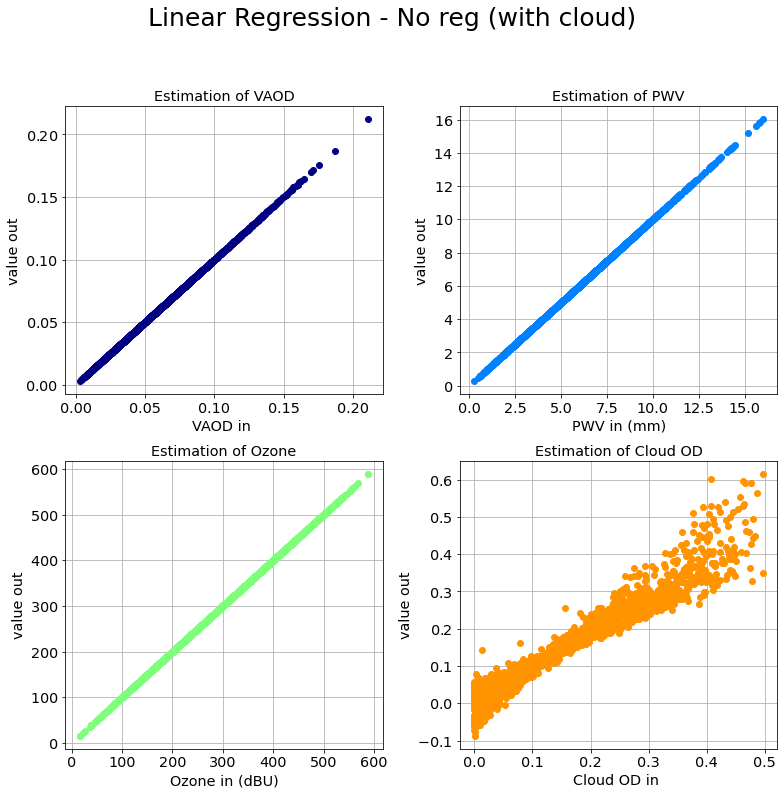

In [178]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

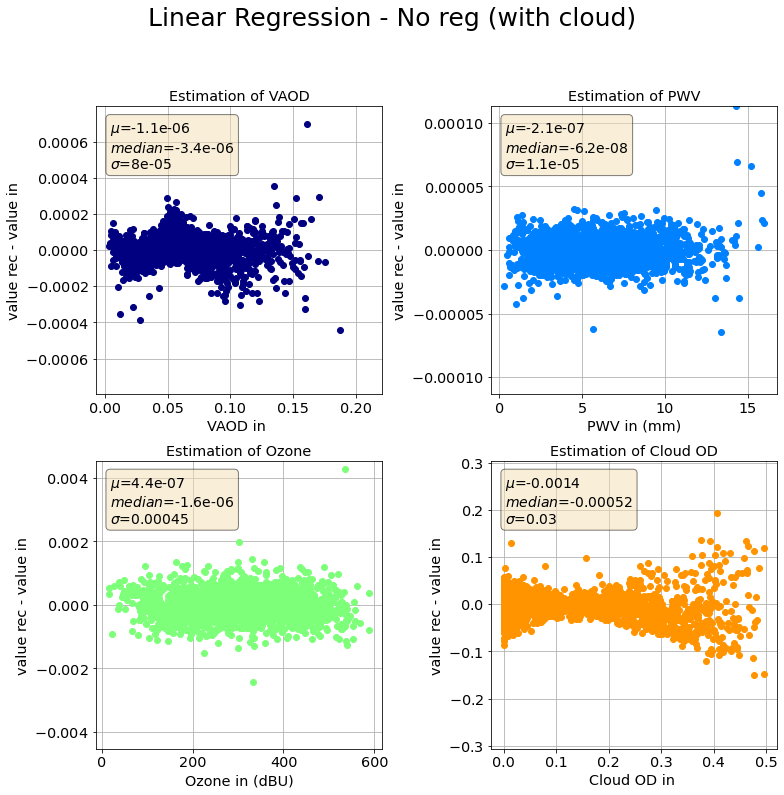

In [179]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

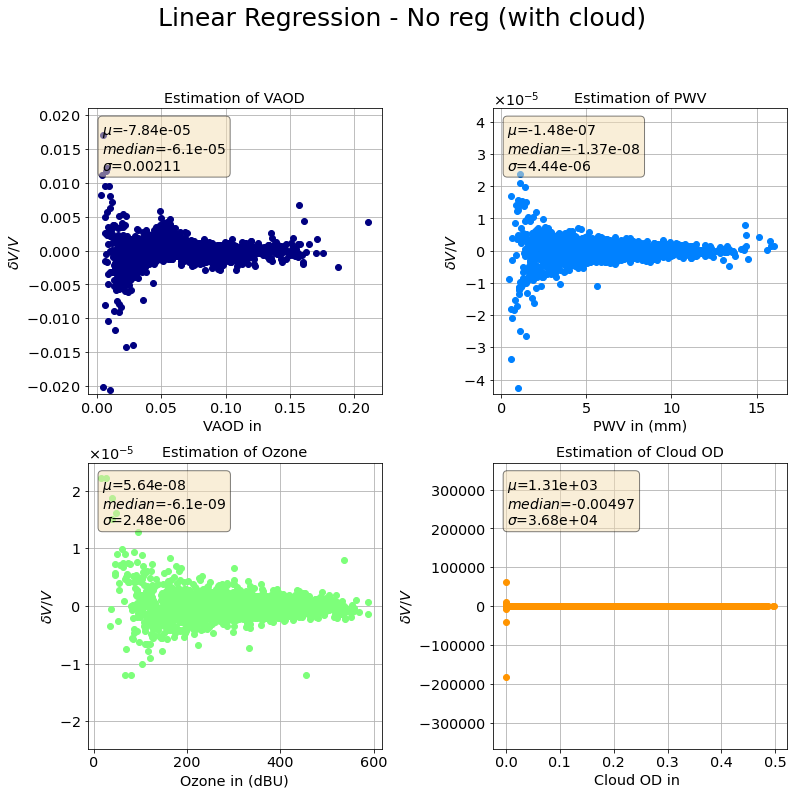

In [180]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()

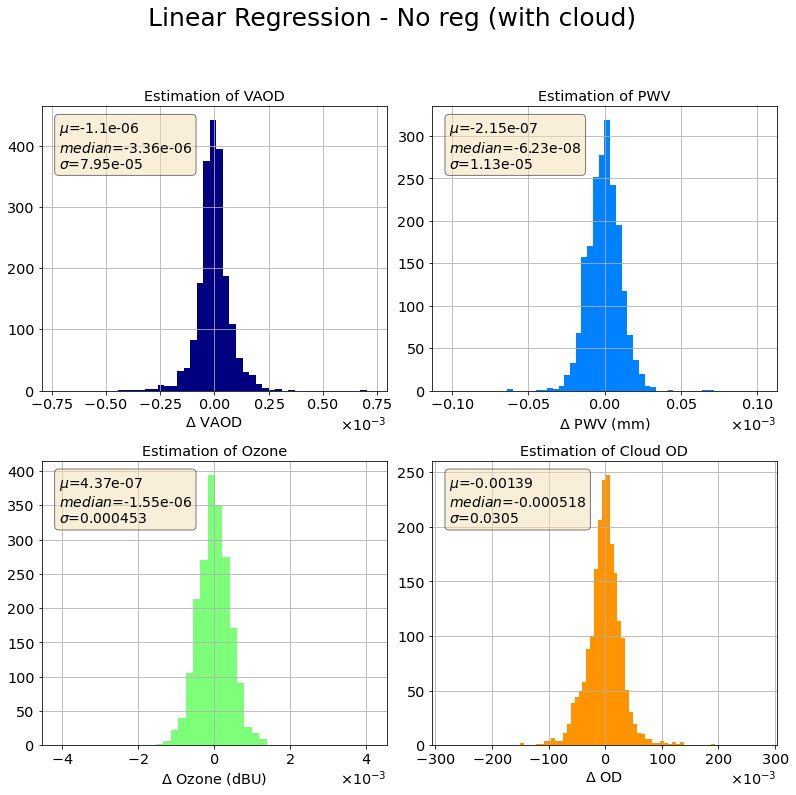

In [181]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.1,fontsize=25)

plt.show()


Text(0.5, 1.05, 'Linear Regression - No reg (with cloud)')

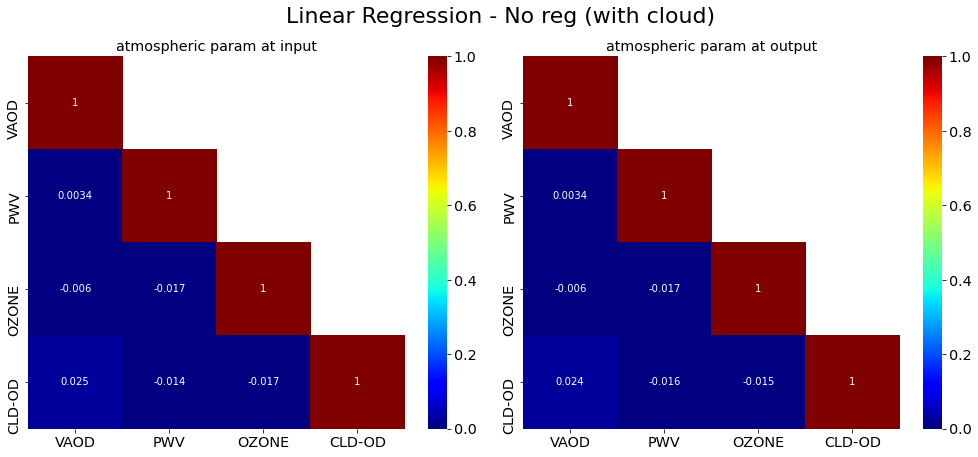

In [182]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud)",Y=1.05,fontsize=22)

## Ridge

In [183]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [184]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.01276
Coefficient of determination: 0.98753
Explained variance: 0.98755


In [185]:
ridge.coef_

array([[-0.48858842, -0.01565353,  0.18557084, ...,  1.6052246 ,
         1.65179415,  1.72469507],
       [ 0.07978793,  0.03294087,  0.01291849, ..., -0.08396721,
        -0.08806677, -0.09901701],
       [ 0.49934713,  0.22706183,  0.11074772, ..., -0.43374141,
        -0.45747288, -0.4939512 ],
       [-0.13197045, -0.15052427, -0.15182325, ..., -0.39463904,
        -0.43413192, -0.51516728]])

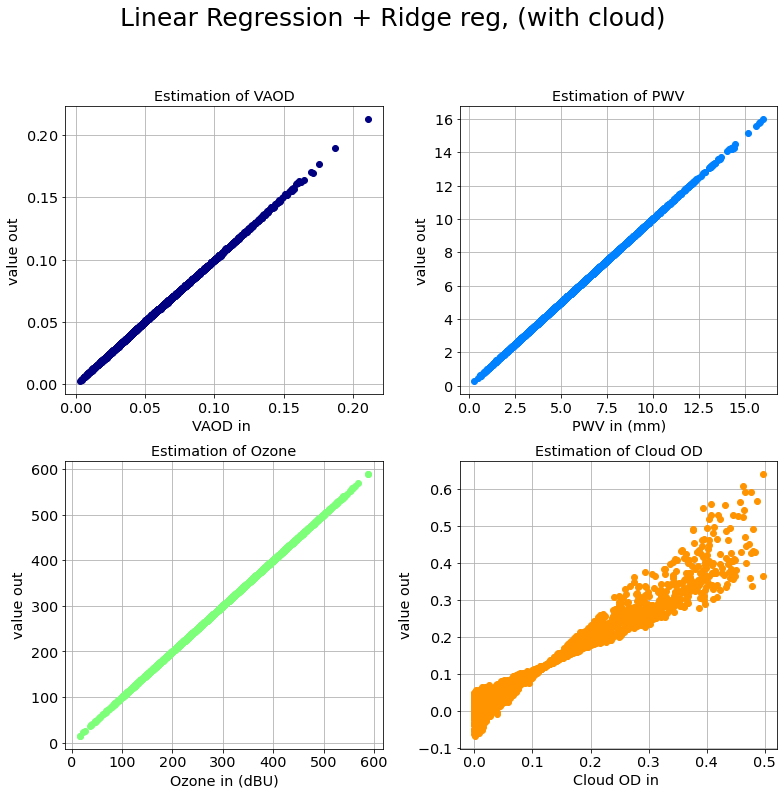

In [186]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

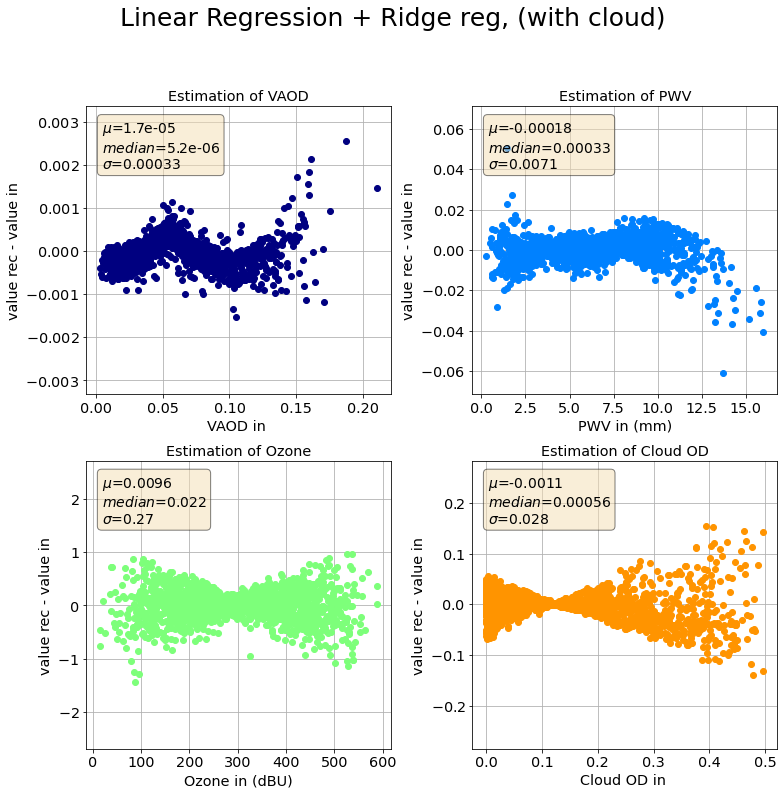

In [187]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

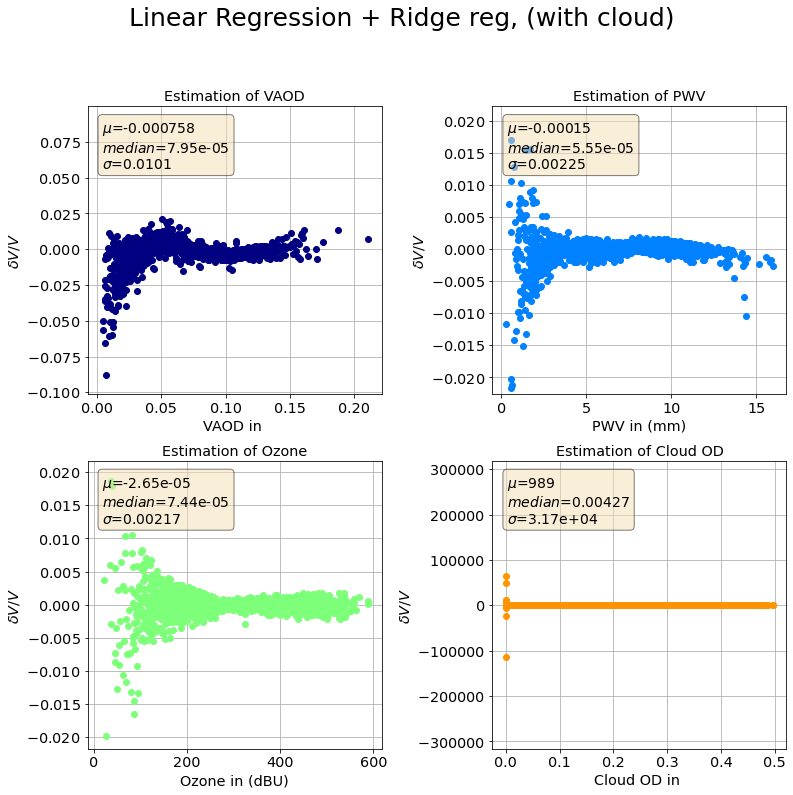

In [188]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

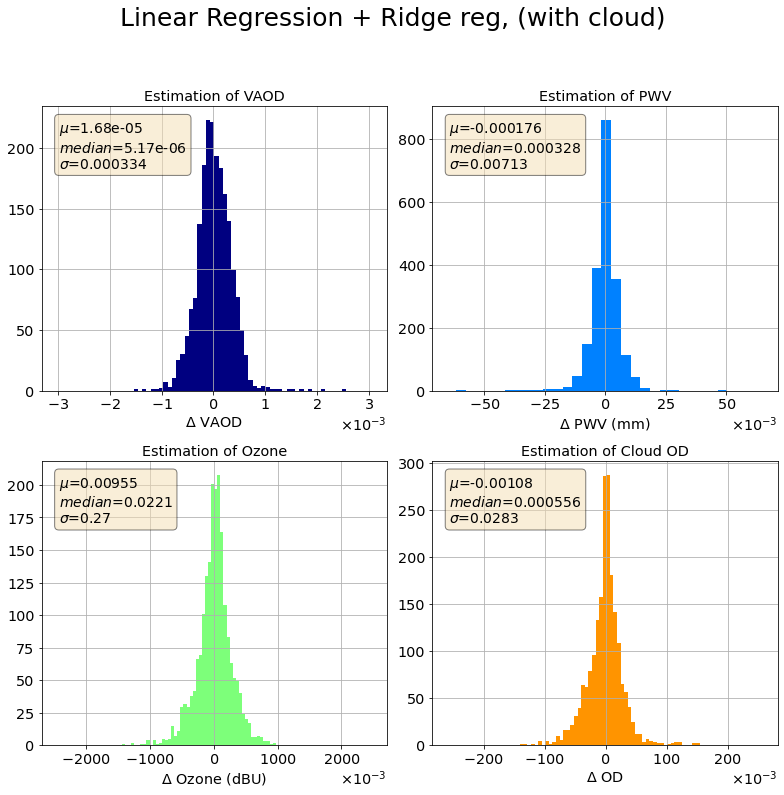

In [189]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

Text(0.5, 1.05, 'Linear Regression - Ridge (with cloud)')

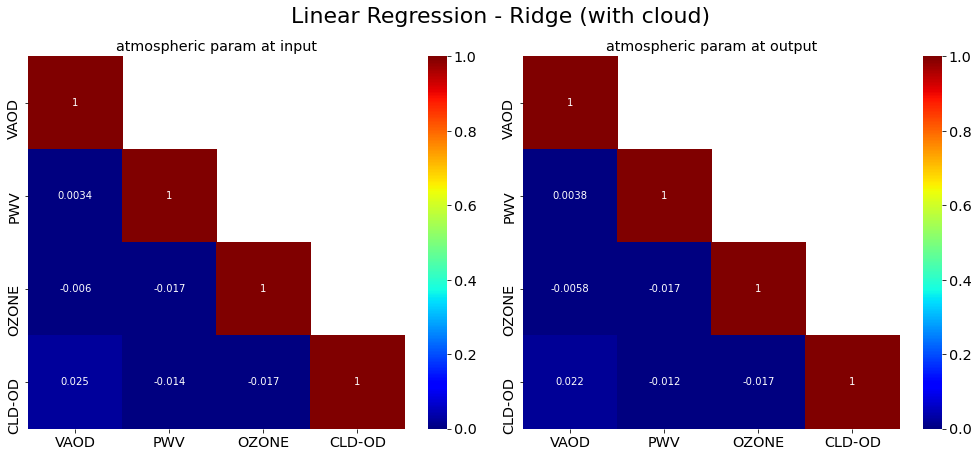

In [190]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - Ridge (with cloud)",Y=1.05,fontsize=22)

## Lasso

In [191]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097.7526876295694, tolerance: 0.5999999999999998
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175.11755608273876, tolerance: 0.5999999999999999
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1914.3321093614495, tolerance: 0.6000000000000036
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

In [192]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.06938
Coefficient of determination: 0.92925
Explained variance: 0.92927


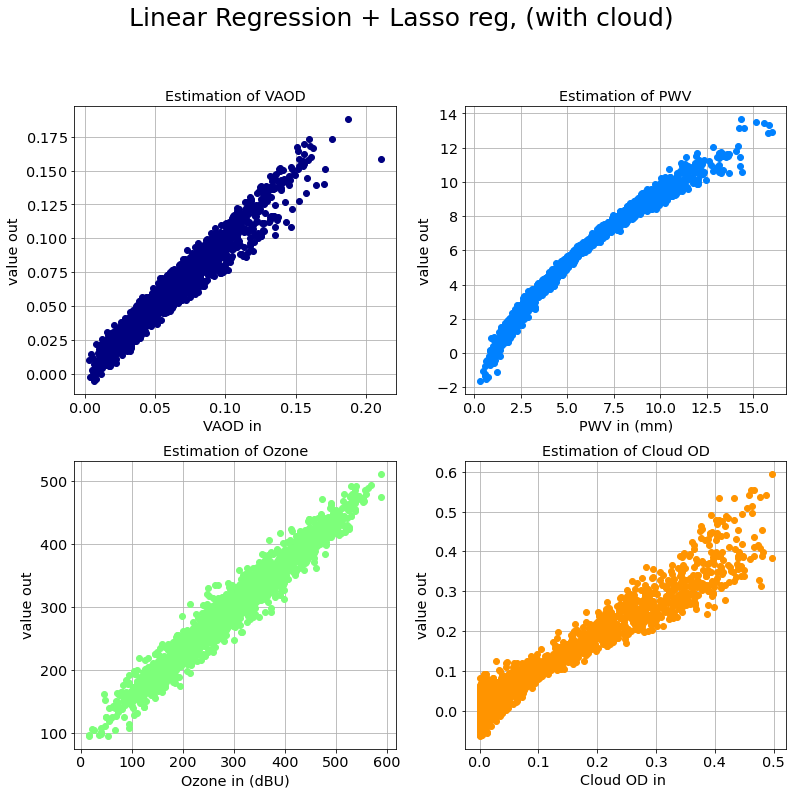

In [193]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=0)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=0)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

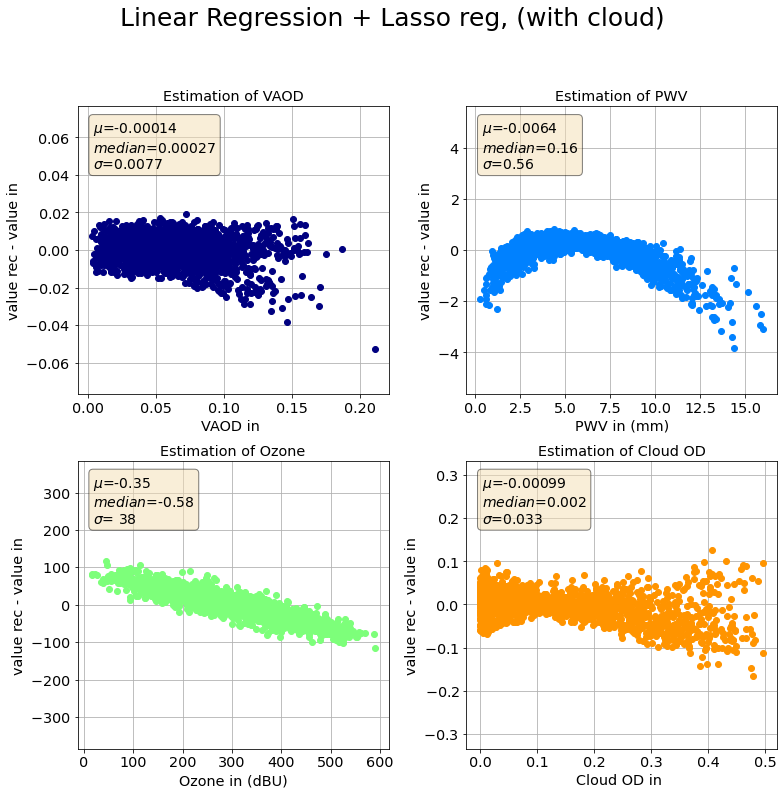

In [194]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=1)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=1)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

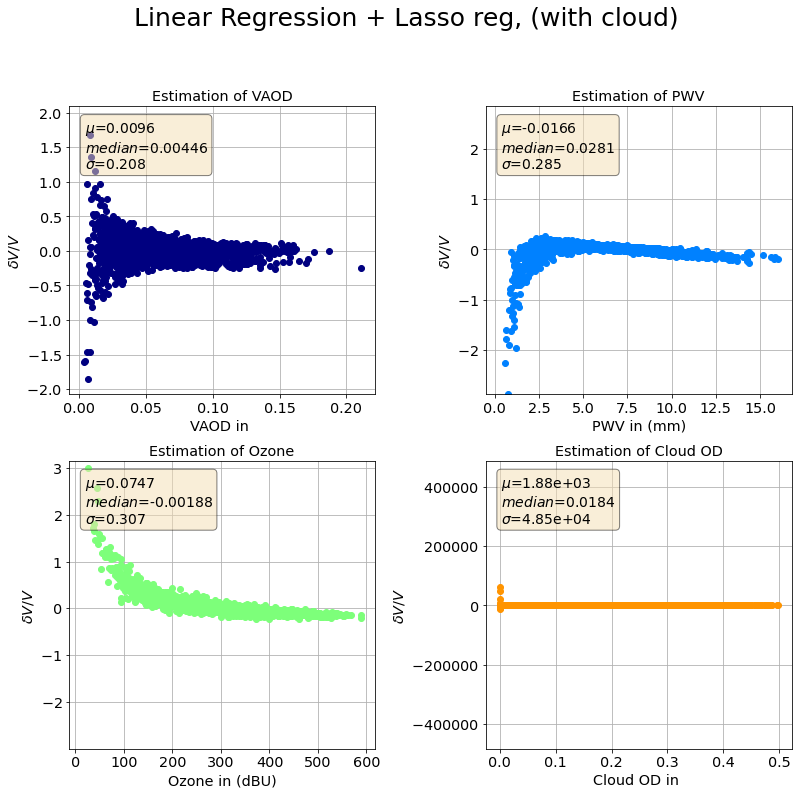

In [195]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param(0,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(222)
plot_param(1,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(223)
plot_param(2,ax,Y_test,Y_pred_test_inv,mode=2)

ax = fig.add_subplot(224)
plot_param(3,ax,Y_test,Y_pred_test_inv,mode=2)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

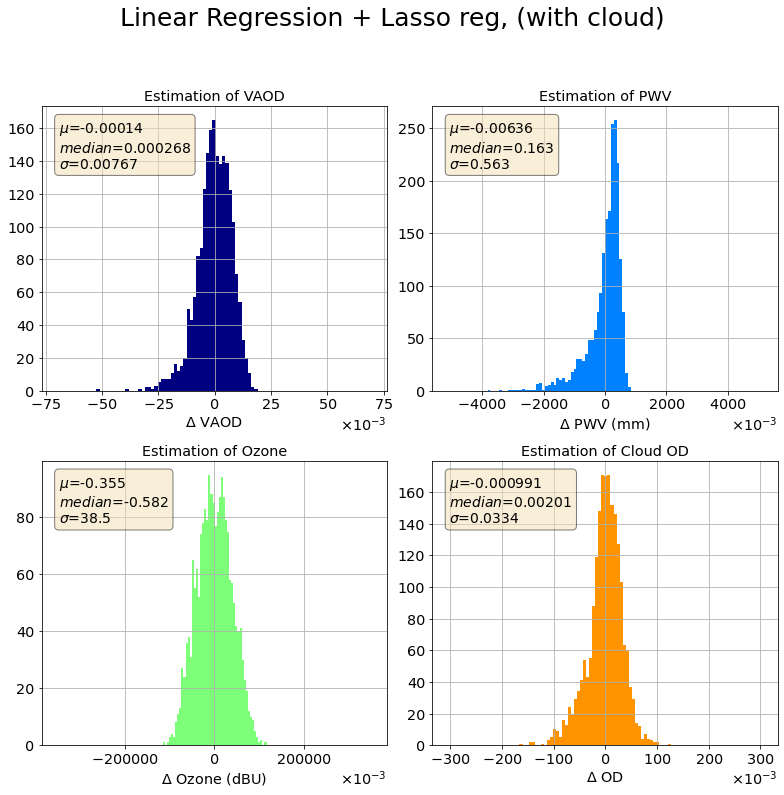

In [196]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
plot_param_histo(0,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(222)
plot_param_histo(1,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(223)
plot_param_histo(2,ax,Y_test,Y_pred_test_inv)

ax = fig.add_subplot(224)
plot_param_histo(3,ax,Y_test,Y_pred_test_inv)

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud)",Y=1.1,fontsize=25)

plt.show()

Text(0.5, 1.05, 'Linear Regression - Lasso (with cloud)')

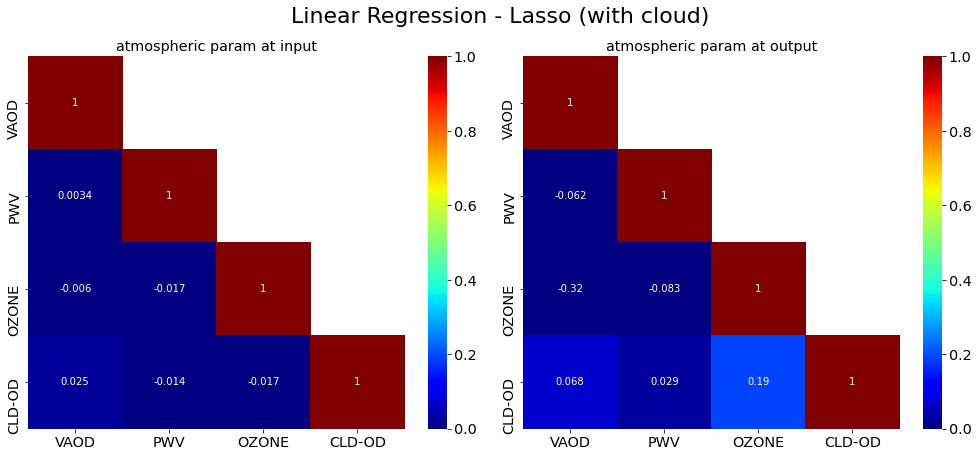

In [198]:
fig=plt.figure(figsize=(14,6))
ax = fig.add_subplot(121)
plotcorrelation(ax,Y_test)
ax.set_title("atmospheric param at input")
ax = fig.add_subplot(122)
plotcorrelation(ax,Y_pred_test_inv)
ax.set_title("atmospheric param at output")
plt.tight_layout()
plt.suptitle("Linear Regression - Lasso (with cloud)",Y=1.05,fontsize=22)